## Python Necessities 

### Import Dependencies

In [ ]:
# General Packages
import math
import os
from pathlib import Path

# data handling libraries
import pandas as pd
import numpy as np
from tabulate import tabulate
import csv
from datetime import datetime
import time

# visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# extra libraries
import warnings
warnings.filterwarnings('ignore')

# Packages to support NN

# sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#tensorflow
import tensorflow as tf
from tensorflow import keras

# Keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

df = None

### Load the data

In [ ]:
# Load data from a folder called data within my project file
#  .. my_project
#     |
#     |___code
#     |   |
#     |   |__ CS3500_Starter_Notebook.ipynb
#     |
#     |___data
#         |
#         |__ credit_score.csv
#
#---------------------------------------------------------------

# # Get the current working directory
# current_dir = os.getcwd() 

# # Construct a path to the parent directory
# parent_dir = os.path.dirname(current_dir)

# # Access a file in the parent directory
# file_path = os.path.join(parent_dir, "data/credit_score_data.csv")

# # Load Credit Score data
# df = pd.read_csv(file_path) 

def loadData():
    global df
    """Load the credit score dataset and display summary statistics."""
    print("\nLoading and cleaning input data set:")
    print("************************************")
    start_time = time.time()
    
    # Get the current working directory
    current_dir = os.getcwd() 

    # Construct a path to the parent directory
    parent_dir = os.path.dirname(current_dir)

    # Access a file in the parent directory
    file_path = os.path.join(parent_dir, "data\credit_score_data.csv")
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Starting Script")
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Loading training data set")
    
    try:
        # Load Credit Score data
        df = pd.read_csv(file_path) 
        total_columns = df.shape[1]
        total_rows = df.shape[0]
        end_time = time.time()
        
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Total Columns Read: {total_columns}")
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Total Rows Read: {total_rows}")
        print(f"\nTime to load is: {round(end_time - start_time, 2)} seconds")
        
        return df
    except FileNotFoundError:
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Error: File not found at {file_path}")
        return None

### Custom Functions For Data Cleaning

In [ ]:
def describe_numerical_column(series, col_name):
    '''Describe a numerical column using describe function of series, report number of null values, display boxplots and histograms.
    Return min, max, IQR based outlier lower range and IQR based outlier upper range as a dictionary.'''
    # print(series.describe(), end = '\n\n')

    # print(f'Number of null values: {series.isnull().sum()}', '\n\n')
    
    # fig, ax = plt.subplots(2, 1, figsize = (8, 8), sharex = True)
    # sns.boxplot(series, orient = 'h', ax = ax[0])
    # ax[0].set_title(f'Distribution of {col_name}')
    # ax[0].tick_params(left = False, labelleft = False) 
    # sns.histplot(series, ax = ax[1])
    # ax[1].set_ylabel('Frequency')
    # ax[1].set_xlabel(col_name)
    # plt.show();

    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    
    return  {'Min. value': series.min(), 'Outlier lower range': q1 - 1.5 * IQR, 'Outlier upper range': q3 + 1.5 * IQR, 'Max. value': series.max()}

def summarize_numerical_column_with_deviation(data, num_col, group_col = 'Customer_ID', absolute_summary = True, median_standardization_summary = False):
    '''Summarize the numerical column and its median standardization based on customers using describe_numerical_column function.'''
    Summary_dict = {}
    
    if absolute_summary == True:
        # print(f'Column description for {num_col}:\n')
        Summary_dict[num_col] = describe_numerical_column(data[num_col], num_col)
        
    if median_standardization_summary == True:
        # if absolute_summary == True:
        #     print('\n')
        default_MAD = return_max_MAD(data, num_col, group_col)
        num_col_standardization = data.groupby(group_col)[num_col].apply(median_standardization, default_value = default_MAD)
        # print(f'Median standardization for {num_col}:\n')
        Summary_dict[f'Median standardization of {num_col}'] = describe_numerical_column(num_col_standardization, f'Median standardization of {num_col}')
        Summary_dict['Max. MAD'] = default_MAD
    return Summary_dict

def return_max_MAD(data, num_col, group_col = 'Customer_ID'):
    '''Return max value of median absolute devaition(MAD) from within the customers for num_col'''
    return (data.groupby(group_col)[num_col].agg(lambda x: (x - x.median()).abs().median())).max()
    
def validate_age(x):
    '''Check whether 8-months period age for a customer is logically valid or not'''
    diff = x.diff()
    if (diff == 0).sum() == 7:
        return True
    elif ((diff.isin([0, 1])).sum() == 7) and ((diff == 1).sum() == 1):
        return True
    else:
        return False
        
def median_standardization(x, default_value):
    '''Transform series or dataframe to its devaition from median with respect to Median absolute deviation(MAD) i.e. median standardization.'''
    med = x.median() 
    abs = (x - med).abs()
    MAD = abs.median()
    if MAD == 0:
        if ((abs == 0).sum() == abs.notnull().sum()): # When MAD is zero and all non-null values are constant in x
            return x * 0
        else:
            return (x - med)/default_value # When MAD is zero but all non-values are not same in x
    else:
        return (x - med)/MAD # When MAD is non-zero

def return_num_of_modes(x):
    '''Return number of modes in given series or dataframe'''
    return len(x.mode())

def return_mode(x):
    '''Return nan if no mode exists in given series or return minimum mode'''
    modes = x.mode()
    if len(modes) == 0:
        return np.nan
    return modes.min()

def forward_backward_fill(x):
    '''Perform forward fill then backward fill on given series or dataframe'''
    return x.fillna(method='ffill').fillna(method='bfill')

def return_mode_median_filled_int(x):
    '''Return back series by filling with mode(in case there is one mode) else fill with integer part of median'''
    modes = x.mode()
    if len(modes) == 1:
        return x.fillna(modes[0])
    else:
        return x.fillna(int(modes.median()))

def return_mode_average_filled(x):
    '''Return back series by filling with mode(in case there is one mode) else fill with average of modes'''
    modes = x.mode()
    if len(modes) == 1:
        return x.fillna(modes[0])
    else:
        return x.fillna(modes.mean())

def fill_month_history(x):
    '''Return months filled data for 8-months period'''
    first_non_null_idx = x.argmin()
    first_non_null_value = x.iloc[first_non_null_idx]
    return pd.Series(first_non_null_value + np.array(range(-first_non_null_idx, 8-first_non_null_idx)), index = x.index)

### Custom Functions For Neural Networks Visuals

In [ ]:
# Function to evaluate predicted vs test data categorical variables
def plot_prediction_vs_test_categorical(y_test, y_pred, class_labels):
    # Plots the prediction vs test data for categorical variables.

    # Args:
    #     y_test (array-like): True labels of the test data.
    #     y_pred (array-like): Predicted labels of the test data.
    #     class_labels (list): List of class labels.

    # Create a confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Calculates performance of multivariate classification model
def calculate_performance_multiclass(y_true, y_pred):
    # Calculates various performance metrics for multiclass classification.

    # Args:
    #     y_true: The true labels.
    #     y_pred: The predicted labels.

    # Returns:
    #     A dictionary containing the calculated metrics.

    metrics = {}

    # Accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # Precision, Recall, and F1-score (macro-averaged)
    metrics['precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['f1_score'] = f1_score(y_true, y_pred, average='macro')

    # Confusion Matrix
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)

    return metrics

### Dataset pre-processing

### Dropping unnecessary columns, data cleaning and correcting data types

**Note:**  
Ideally data cleaning should be done in parallel to discussions with domain expert to understand what values are appropriate in the columns, can they be retrieved if missing and do the columns depend upon each other. Unfortunately, such kind of support is not available in this kaggle project and therefore, we will deal with the data as per our understanding approximately.

Looking at the dataset info, many of the columns in our dataset have null values within them, representing missing values. Also, some columns are not of the correct data type as per the data they hold, this means there might be some textual characters within the data indicating unclean data and maybe placeholders which describe non-existing data or missing data and therefore, that is not getting captured as null values but as strings. We need to identify these values and first change them to null values before we do any further pre-processing.

We will look at the columns one by one. Only columns which need some cleaning will be dealt with below.

## Data Cleaning function

In [ ]:
def dataCleaning():
    global df

    print("Process (Clean) data:")
    print("*********************")
    start_time = time.time()

    # Cleaning start
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')} Performing Data Clean Up")

    # #### 1. Customer ID

    # %%
    df['Customer_ID'].unique()

    # %%
    df['Customer_ID'].nunique()

    df['Customer_ID'].str.contains('CUS_0x').value_counts()

    # #### 2. Name
    df.drop(columns = ['Name'], inplace = True)

    # #### 3. Age
    df['Age'][~df['Age'].str.isnumeric()].unique() #extracting non-numeric textual data
    df['Age'] = df['Age'].str.replace('_', '')
    df['Age'][~df['Age'].str.isnumeric()].unique()
    df['Age'] = df['Age'].astype(int)

    # #### 4. SSN
    df.drop(columns = ['SSN'], inplace = True)

    # #### 5. Occupation
    df['Occupation'][df['Occupation'] == '_______'] = np.nan

    # #### 6. Annual Income
    df['Annual_Income'][~df['Annual_Income'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique() # using regex to find values which don't follow the patern of a float
    df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')
    df['Annual_Income'][~df['Annual_Income'].str.fullmatch('([0-9]*[.])?[0-9]+')]
    df['Annual_Income'] = df['Annual_Income'].astype(float)

    # #### 7. Number of Loans

    df['Num_of_Loan'][~df['Num_of_Loan'].str.isnumeric()].unique()
    df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '').astype(int)

    # #### 8. Number of delayed payments
    temp_series = df['Num_of_Delayed_Payment'][df['Num_of_Delayed_Payment'].notnull()]

    temp_series[~temp_series.str.isnumeric()].unique()
    df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '').astype(float)

    # #### 9. Changed Credit Limit
    df['Changed_Credit_Limit'][~df['Changed_Credit_Limit'].str.fullmatch('[+-]?([0-9]*[.])?[0-9]+')].unique()
    df['Changed_Credit_Limit'][df['Changed_Credit_Limit'] == '_'] = np.nan 
    df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float)

    # #### 10. Credit Mix
    df['Credit_Mix'][df['Credit_Mix'] == '_'] = np.nan

    # #### 11. Outstanding debt
    df['Outstanding_Debt'][~df['Outstanding_Debt'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique()
    df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')
    df['Outstanding_Debt'][~df['Outstanding_Debt'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique()
    df['Outstanding_Debt'] = df['Outstanding_Debt'].astype(float)
    
    # #### 12. Amount Invested Monthly
    temp_series = df['Amount_invested_monthly'][df['Amount_invested_monthly'].notnull()]
    temp_series[~temp_series.str.fullmatch('([0-9]*[.])?[0-9]+')].unique()
    df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('_', '').astype(float)

    # #### 13. Payment Behaviour
    df['Payment_Behaviour'][df['Payment_Behaviour'] == '!@9#%8'] = np.nan

    # #### 14. Monthly Balance
    temp_series = df['Monthly_Balance'][df['Monthly_Balance'].notnull()]
    temp_series[temp_series.str.fullmatch('[+-]*([0-9]*[.])?[0-9]+') == False].unique()
    df['Monthly_Balance'][df['Monthly_Balance'] == '__-333333333333333333333333333__'] = np.nan
    df['Monthly_Balance'] = df['Monthly_Balance'].astype(float)
    df['Month'] = df['Month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8})
    df.sort_values(by = ['Customer_ID', 'Month'], ignore_index = True, inplace = True)
    df.drop(columns = 'ID', inplace = True)
    df.head(8)
    df_copy = df.copy()

    # #### 1. Age 
    df['Age'][(df['Age'] > 100) | (df['Age'] <= 0)] = np.nan 
    summary_age = summarize_numerical_column_with_deviation(df, 'Age', median_standardization_summary = True)
    df['Age'][df.groupby('Customer_ID')['Age'].transform(median_standardization, default_value = return_max_MAD(df, 'Age')) > 80] = np.nan
    df['Age'] =  df.groupby('Customer_ID')['Age'].transform(forward_backward_fill).astype(int)
    df.groupby('Customer_ID')['Age'].nunique().value_counts()

    df.groupby('Customer_ID')['Age'].agg(validate_age).value_counts()

    # #### 2. Occupation 
    df['Occupation'].isnull().sum()
    df.groupby('Customer_ID')['Occupation'].nunique().value_counts()
    df.groupby('Customer_ID')['Occupation'].count().value_counts()
    df['Occupation'] = df.groupby('Customer_ID')['Occupation'].transform(forward_backward_fill)
    df['Occupation'].isnull().sum()

    # #### 3. Annual Income and monthly inhand salary
    summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

    summary_monthly_inhand_salary = summarize_numerical_column_with_deviation(df, 'Monthly_Inhand_Salary', 'Customer_ID', True, True)

    df.groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_num_of_modes).value_counts()
    df[df.groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_num_of_modes) == 2]
    df['Annual_Income'][df['Monthly_Inhand_Salary'].notnull()] = df[df['Monthly_Inhand_Salary'].notnull()].groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_mode)

    summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

    df['Monthly_Inhand_Salary'] = df.groupby(['Customer_ID', 'Annual_Income'], group_keys = False)['Monthly_Inhand_Salary'].transform(forward_backward_fill)
    df['Monthly_Inhand_Salary'].isnull().sum()
    Annual_Income_deviation = df.groupby('Customer_ID', group_keys = False)['Annual_Income'].apply(lambda x: (x - x.median())/x.median())
    temp = Annual_Income_deviation[df['Monthly_Inhand_Salary'].isnull()]

    # print(temp.describe())
    df['Annual_Income'][df['Monthly_Inhand_Salary'].isnull()] = np.nan
    Annual_Income_deviation = df.groupby('Customer_ID', group_keys = False)['Annual_Income'].apply(lambda x: (x - x.median())/x.median())
    Annual_Income_deviation[Annual_Income_deviation > 500]
    df.iloc[[34042]]
    df[df['Customer_ID'].isin(['CUS_0x6079'])]

    df.loc[[34042], ['Annual_Income', 'Monthly_Inhand_Salary']] = np.nan

    df['Annual_Income'] = df.groupby('Customer_ID')['Annual_Income'].transform(forward_backward_fill)
    df['Monthly_Inhand_Salary'] = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(forward_backward_fill)
    summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)
    summary_monthly_inhand_salary = summarize_numerical_column_with_deviation(df, 'Monthly_Inhand_Salary', 'Customer_ID', True, False)
    
    # #### 4. Number of Bank Accounts
    summary_num_bank_accounts = summarize_numerical_column_with_deviation(df, 'Num_Bank_Accounts', median_standardization_summary = True)
    summary_num_bank_accounts

    df['Num_Bank_Accounts'][df['Num_Bank_Accounts'] < 0] = np.nan
    df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts')).value_counts()
    np.sort((df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts'))).unique())[:10]
    df['Num_Bank_Accounts'][df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts')).abs() > 2] = np.nan
    summary_num_bank_accounts = summarize_numerical_column_with_deviation(df, 'Num_Bank_Accounts', median_standardization_summary = True)
    df['Num_Bank_Accounts'] = df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(forward_backward_fill).astype(int)
    df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(pd.Series.diff).value_counts()

    df.groupby('Customer_ID')['Num_Bank_Accounts'].agg(lambda x: x.diff().sum()).value_counts()

    # #### 5. Number of credit cards
    summary_num_credit_cards = summarize_numerical_column_with_deviation(df, 'Num_Credit_Card', median_standardization_summary = True)
    summary_num_credit_cards
    df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card')).value_counts()
    np.sort((df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card'))).unique())[:10]

    df['Num_Credit_Card'][df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card')).abs() > 2] = np.nan

    summary_num_credit_cards = summarize_numerical_column_with_deviation(df, 'Num_Credit_Card', median_standardization_summary = True)
    df['Num_Credit_Card'] = df.groupby('Customer_ID')['Num_Credit_Card'].transform(forward_backward_fill).astype(int)
    df.groupby('Customer_ID')['Num_Credit_Card'].transform(pd.Series.diff).value_counts()

    df.groupby('Customer_ID')['Num_Credit_Card'].agg(lambda x: x.diff().sum()).value_counts()

    # #### 6. Interest Rate

    # %%
    summary_interest_rate = summarize_numerical_column_with_deviation(df, 'Interest_Rate', median_standardization_summary = True)

    # %%
    summary_interest_rate

    # %%
    df.groupby('Customer_ID')['Interest_Rate'].nunique().value_counts()

    # %% [markdown]
    # What we observe is MAD is 0(since max. MAD is 0) for each customer. Thus, it is hard to look at median standardization and assess points using this. Lets try to look at deviation from median. Since interest rate is not a feature whose median should deviate too much in scale from customer to customer.

    # %%
    deviation_from_median = df.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: (x - x.median()))

    # %%
    deviation_from_median.describe()

    # %%
    deviation_from_median.value_counts()

    # %%
    np.sort(deviation_from_median.unique())

    # %% [markdown]
    # Looking at the above data indicates that either interest rate is same as median or varies by at least 37% difference or more which is almost never seen in real life. We will fill all the records of customer with customer's median.

    # %%
    df['Interest_Rate'] = df.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: x.median())

    # %%
    df['Interest_Rate'].describe()

    # %% [markdown]
    # #### 7. Number of loans

    # %%
    summary_num_of_loans = summarize_numerical_column_with_deviation(df, 'Num_of_Loan')

    # %% [markdown]
    # There are clearly some outliers as the number of loans can't be these many.

    # %% [markdown]
    # The type of loans column can be used to extract this information accurately as the loans taken, their order and the count is embedded inside type of loan column.

    # %%
    df['Type_of_Loan'].isnull().sum()

    # %% [markdown]
    # There are 11408 null values inside type of loan column which were added by us after replacing the placeholder. Maybe these represent no loans. Lets extract the loans count from type of loan column and fill it in num of loans column.

    # %%
    num_of_loans = df['Type_of_Loan'].str.split(', ').str.len()

    # %%
    df['Num_of_Loan'][num_of_loans.notnull()] = num_of_loans[num_of_loans.notnull()]

    # %% [markdown]
    # We have changed the values of number of loans columns for which we had valid data from type of loan column. Lets look at the values in number of loans column which were not touched.

    # %%
    df['Num_of_Loan'][num_of_loans.isnull()].value_counts()

    # %%
    np.sort(df['Num_of_Loan'][num_of_loans.isnull()].value_counts().index)

    # %% [markdown]
    # Mostly these are 0 which represent no loans. Other than this there are either negative values or too high values to be representing real count for number of loans. Looking at the data, we can assume here that all these are erroneous values and should actually be 0 i.e. specifying no loans.

    # %%
    df['Num_of_Loan'][num_of_loans.isnull()] = 0

    # %%
    df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(forward_backward_fill).astype(int)

    # %% [markdown]
    # What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high.

    # %%
    df.groupby('Customer_ID')['Num_of_Loan'].transform(pd.Series.diff).value_counts()

    # %% [markdown]
    # This means that number of loans remain same throughout the 8-months period for each customer.

    # %% [markdown]
    # #### 8. Type of loan

    # %%
    df['Type_of_Loan'].value_counts()

    # %% [markdown]
    # Here we see that the placeholder 'Not Specified' has been used as a way of indicating that the type of loan has not been specified by the customer. 

    # %%
    df['Type_of_Loan'].nunique()

    # %%
    df['Type_of_Loan'].isnull().sum()

    # %% [markdown]
    # Total 11408 null values. As noted earlier with number of loans these most probably represent no loans.

    # %% [markdown]
    # We can replace the same with our own placeholder for that - 'No Loan'.

    # %%
    df['Type_of_Loan'].fillna('No Loan', inplace = True)

    # %% [markdown]
    # Lets seen what and how many unique type of loans we have.

    # %%
    temp_series = df['Type_of_Loan']

    # %%
    temp_lengths = temp_series.str.split(', ').str.len().astype(int) # Number of loans

    # %%
    temp_lengths_max = temp_lengths.max()

    # %%
    for index, val in temp_lengths.items():
        temp_series[index] = (temp_lengths_max - val) * 'No Loan, ' + temp_series[index]

    # %%
    temp_series.head()

    # %%
    temp = temp_series.str.split(pat = ', ', expand = True)
    unique_loans = set()
    for col in temp.columns:
        temp[col] = temp[col].str.lstrip('and ')
        unique_loans.update(temp[col].unique())
    # print(unique_loans)

    # %%
    len(unique_loans)

    # %% [markdown]
    # There are total 8 unique type of loans, one placeholder for no specification of loan type and one placeholder added by us to specify there is no loan.

    # %% [markdown]
    # When we are working with tree based models usually they don't need the categorical columns to be encoded to numerical data type like we need for linear regression, logistic regression etc. as the model can handle these. But scikit learn uses CART algorithm and there is no functionality of using categorical variables directly and thus, for modelling with scikit-learn they need to be numerically encoded. Right now in this column we have 6260 unique categories which is too much to search for at one node. as at each node, a decision tree will look at all possible values of the categorical column to figure out what value produces the best split based on gini impurity or entropy decrease on splitting. We can do some pre-prcoessing on this column to split it into multiple columns. Intutively, it feels like the lastest loan should have high influence on your credit score because if the loan is heavy in nature then it might lead to poor credit score if unable to pay while if it is light then the credit score should remain almost same as before. We can split the column in following format: Latest loan1, latest loan2 etc. This way we will have 9 columns corresponding to maximum number of loans for any customer and each column can have maximum 10 categorical values corresponding to the unqiue loans calculated above. 

    # %% [markdown]
    # This approach will have following benefits:  
    # 1. Preserves the order of loans even after splitting.
    # 2. Easier to visualize and understand patterns since number of categories per column reduces.    
    # 3. Algorithm can focus more on information contained within the loan sequence. For example, if second last and third last loan contain critical information in classifying credit score than focussing on whole sequence of loans is not worthwhile and this inturn might lead to smaller decision trees and faster training compared to if we didn't split.  
    # 4. At each node for 9 of the splitted columns only total 90(9 columns * 10 categories) comparisons need to be made after one-hot encoding rather than 6260 comparisons for one non-splitted column.

    # %% [markdown]
    # Another possible approach could be to split columns as first loan, second loan etc. as a way of splitting but the pre-processing mentioned above feels more effective for now. We will maybe look at these two modeling startegies whn we do EDA and modeling.

    # %%
    temp.columns = [f'Last_Loan_{i}' for i in range(int(df['Num_of_Loan'].max()), 0, -1)]

    # %%
    temp.head()

    # %%
    df = pd.merge(df, temp, left_index = True, right_index = True)

    # %%
    df.head()

    # %% [markdown]
    # We can drop the type of loan column from dataset.

    # %%
    df.drop(columns = 'Type_of_Loan', inplace = True)

    # %% [markdown]
    # #### 9. Delay from due date

    # %%
    summary_due_date = summarize_numerical_column_with_deviation(df, 'Delay_from_due_date', median_standardization_summary = True)

    # %%
    summary_due_date

    # %% [markdown]
    # The median standardization varies quite a bit going from -10 to 11. 

    # %%
    due_date_deviation = df.groupby('Customer_ID')['Delay_from_due_date'].transform(median_standardization, default_value = return_max_MAD(df, 'Delay_from_due_date'))

    # %% [markdown]
    # Looking at the fact that overall distribution of delay from due date is not too extreme and delay from due date can vary a lot as well unlike number of credit cards or number of bank accounts. We will move forward with the data as it is. Having a domain expert by your side would have helped make this more clearer.

    # %% [markdown]
    # #### 10. Number of delayed payments

    # %%
    summary_num_delayed_payments = summarize_numerical_column_with_deviation(df, 'Num_of_Delayed_Payment', median_standardization_summary = True)

    # %%
    summary_num_delayed_payments

    # %% [markdown]
    # Judging from median standardization, almost all of the values are same as median and this is leading to 0 median standardization. Median standardization should definitely should be like this and should be skewed in nature but its hard to assess what threshold to use without a domain expert. We will use the full column as a sample and judge based on that here.

    # %% [markdown]
    # The number of delayed payments can't be too much and can not be negative as well. We will set negative values and values greater than upper range of oultiers to null.

    # %%
    df['Num_of_Delayed_Payment'][(df['Num_of_Delayed_Payment'] > summary_num_delayed_payments['Num_of_Delayed_Payment']['Outlier upper range']) | (df['Num_of_Delayed_Payment'] < 0)] = np.nan

    # %%
    df['Num_of_Delayed_Payment'].isnull().sum()

    # %% [markdown]
    # There are 8382 null values. Lets observe the count of diff in between consecutive months and observe if we can identify some pattern exising there which can help us make some educated guess about the null values.

    # %%
    df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(pd.Series.diff).value_counts(normalize = True)

    # %% [markdown]
    # Around 45.6% of time it remains same across months but rest of the time it varies i.e more than 50% of the time it varies across months.

    # %%
    df[['Customer_ID', 'Num_of_Delayed_Payment']].head(40)

    # %% [markdown]
    # Looking at the data it looks like usually a single value repeats more often across months i.e. mode might be a suitable choice here. But first lets see that usually how many times the mode occurs for any customer.

    # %%
    # Ratio of frequency of mode and number of non-null data per customer
    temp = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: (x == x.mode()[0]).sum()/x.notnull().sum()).value_counts(normalize = True)

    # %%
    temp[temp.index > 0.5].sum() # Idenitfying how many times the mode occurs in more than 50% of non-null data per customer

    # %% [markdown]
    # That is within given data for around 75.8% of the customers the mode occurs more than 50% of the time within 8-months period for whatever data we have available. This means the mode might be a suitable imputation here.

    # %% [markdown]
    # What if there are multiple modes per customer? Lets check the data if such thing exists.

    # %%
    df.groupby('Customer_ID')['Num_of_Delayed_Payment'].agg(lambda x: len(x.mode())).value_counts()

    # %% [markdown]
    # Mostly, we observe one mode but sometimes it can be more than one as well. What to do in multiple modes case? We can take some average or median of modes in that case, in case there is skewness within the modes, median would be a better guess and in case where medians come out to be floating point number we can just take the integer part as an approximation.

    # %%
    df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(return_mode_median_filled_int).astype(int)

    # %% [markdown]
    # Number of delayed payments is something that can vary from month to month its not like it has monotically increasing pattern or so which we can use as a sanity check. What we can try to observe is the relative devaition from median for this cleaned column.

    # %%
    summarize_numerical_column_with_deviation(df, 'Num_of_Delayed_Payment', median_standardization_summary = True)

    # %% [markdown]
    # #### 11. Changed credit limit

    # %%
    summary_changed_credit_limit = summarize_numerical_column_with_deviation(df, 'Changed_Credit_Limit', median_standardization_summary = True)

    # %% [markdown]
    # Credit card limit is dependent upon the users usage patterns. If the lender trusts the customer then it can increase also and if customer is late on payments, low activity etc. then the credit lmit can decrease as well. Thus, both negative and positive values are understandable.

    # %% [markdown]
    # The upper range for outliers for full column doesn't significantly deviate from the max value and its difficult to judge here what threshold should be placed on credit limit median standardization. Thus, we leave non-null values as it is for now.

    # %%
    df[['Customer_ID', 'Changed_Credit_Limit']].head(40)

    # %% [markdown]
    # Looking at the data usually the credit limit occurs with the same value across months i.e. the mode might be an appropriate value to imputate. Lets do some checks first though.

    # %%
    df.groupby('Customer_ID')['Changed_Credit_Limit'].agg(lambda x: len(x.mode())).value_counts()

    # %% [markdown]
    # Almost all the time only one mode appears. But sometimes two mode can occur as well, since this is a floating point type feature and there are only two mode values we will choose average of both which will be same as median in this case.

    # %%
    df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(return_mode_average_filled)

    # %%
    df['Changed_Credit_Limit'].isnull().sum()

    # %% [markdown]
    # #### 12. Number of credit card inquiries

    # %%
    summary_num_credit_inquiries = summarize_numerical_column_with_deviation(df, 'Num_Credit_Inquiries', median_standardization_summary = True)
    df['Num_Credit_Inquiries'][(df['Num_Credit_Inquiries'] > summary_num_credit_inquiries['Num_Credit_Inquiries']['Outlier upper range']) | (df['Num_Credit_Inquiries'] < 0)] = np.nan

    # %%
    df['Num_Credit_Inquiries'].isnull().sum()

    # %% [markdown]
    # Lets look at some data.

    # %%
    df[['Customer_ID', 'Num_Credit_Inquiries']].head(40)

    # %% [markdown]
    # This a type of data which is monotically increasing in nature and thus should increase or remain same as months go on. Lets check that.

    # %%
    df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(pd.Series.diff).value_counts()

    # %% [markdown]
    # As expected it mostly either remains same or increases. In this case we can just use forward fill and backward fill to fill these nulls.

    # %%
    df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(forward_backward_fill).astype(int)

    # %% [markdown]
    # Lets do the check again.

    # %%
    df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(pd.Series.diff).value_counts()

    # %% [markdown]
    # #### 13. Credit Mix
    df['Credit_Mix'].isnull().sum()

    # %% [markdown]
    # A lot of null values present. We have already seen that during the 8-months period the type of loans and number of loans remain same so its fair to assume credit mix will also remain same. Lets check that with the given data.

    # %%
    df.groupby('Customer_ID')['Credit_Mix'].nunique().value_counts()

    # %% [markdown]
    # We can observe that one customer has only one type of credit mix only, throughout the 8-months period apart from null values. We can just use forward fill and bacward fill to achieve the desired goal.

    # %%
    df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].transform(forward_backward_fill)

    # %%
    df['Credit_Mix'].isnull().sum()

    # %% [markdown]
    # #### 14. Outstanding debt

    # %%
    summary_outstanding_debt = summarize_numerical_column_with_deviation(df, 'Outstanding_Debt', median_standardization_summary = True)

    # %% [markdown]
    # All the values in median standardization are coming out to be zero. Is the outstanding debt constant for each customer across months after ignoring nulls?

    # %%
    df.groupby('Customer_ID')['Outstanding_Debt'].nunique().value_counts()

    # %% [markdown]
    # The column looks ok from the distribution perspective and there are no nulls present.

    # %% [markdown]
    # #### 15. Credit Utilization ratio

    # %%
    summary_credit_utilization_ratio = summarize_numerical_column_with_deviation(df, 'Credit_Utilization_Ratio', median_standardization_summary = True)

    # %% [markdown]
    # Judging from both the graphs its hard to put a threshold on median standardization of credit utilization ratio without a domin expert and also, the distribution of the column as a whole looks decent enough to not touch it further.

    # %% [markdown]
    # #### 16. Credit History Age

    # %%
    df[['Customer_ID', 'Credit_History_Age']].head(40)

    # %%
    df['Credit_History_Age'].isnull().sum()

    # %% [markdown]
    # There are 9030 null values. Looking at the data it is of the format - '{Year} Years and {Months} Months'. Using str functions of pandas series, we can extract these two data values i.e. year and months. We will then combine them in a single column as total months because both the year data and month data can be easily extracted from total months so there will be no loss of information and we will be able to reduce one feature from our dataset.

    # %%
    df[['Years', 'Months']] = df['Credit_History_Age'].str.extract('(?P<Years>\d+) Years and (?P<Months>\d+) Months').astype(float)
    df[['Years', 'Months']].describe()
    df['Credit_History_Age'] = df['Years'] * 12 + df['Months']

    # %%
    df.drop(columns = ['Years', 'Months'], inplace = True)

    df['Credit_History_Age'].isnull().sum()
    df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(fill_month_history).astype(int)

    # #### 17. Payment of minimum amount
    df['Payment_of_Min_Amount'].value_counts()

    df.groupby(['Customer_ID'])['Payment_of_Min_Amount'].nunique().value_counts()

    df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0, 'NM': np.nan})

    df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(pd.Series.diff).value_counts()

    df['Payment_of_Min_Amount'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(lambda x: x.fillna(x.mode()[0]))
    df['Payment_of_Min_Amount'].isnull().sum()
    df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({1: 'Yes', 0: 'No'})

    # #### 18. Total EMI per month
    summary_total_emi_per_month = summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)
    summary_total_emi_per_month

    deviation_total_emi = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(median_standardization, default_value = return_max_MAD(df, 'Total_EMI_per_month'))

    df['Total_EMI_per_month'][deviation_total_emi > 10000] = np.nan
    summary_total_emi_per_month = summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)
    df['Total_EMI_per_month'][(df['Total_EMI_per_month'] > summary_total_emi_per_month['Total_EMI_per_month']['Outlier upper range'])] = np.nan
    df['Total_EMI_per_month'].isnull().sum()
    df.groupby('Customer_ID')['Total_EMI_per_month'].nunique().value_counts()
    deviation_total_emi = df_copy.groupby('Customer_ID', group_keys = False)['Total_EMI_per_month'].transform(median_standardization, default_value = return_max_MAD(df_copy, 'Total_EMI_per_month'))

    # %%
    temp = (deviation_total_emi[df.groupby('Customer_ID')['Total_EMI_per_month'].transform(pd.Series.nunique) == 0])

    # %% [markdown]
    # Looking at this, only one value looks absurdly big. The rest of the median standardization's could even be considered ok for now.

    # %%
    temp[temp > 80]

    # %% [markdown]
    # Lets convert this value to null and feed it back to the dataset.

    # %%
    temp[79370] = np.nan
    df['Total_EMI_per_month'][temp.index] = temp

    # %%
    summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

    # %% [markdown]
    # Now the data looks more appropriate compared to before. There are still 4420 null values which need to be handled here.

    # %% [markdown]
    # The rest of the null values can be filled using forward and backward fill as the EMI's should be highly dependent upon previous month.

    # %%
    df['Total_EMI_per_month'] = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(forward_backward_fill)

    # %%
    df['Total_EMI_per_month'].isnull().sum()

    # %% [markdown]
    # #### 19. Amount Invested Monthly

    # %%
    summary_amount_invested_monthly = summarize_numerical_column_with_deviation(df, 'Amount_invested_monthly', median_standardization_summary = True)

    # %% [markdown]
    # Some values in amount invested monthly are too extreme compared to the rest of the data and thus, can be removed considering them to be erroneous before we do further processing.

    # %%
    df['Amount_invested_monthly'][df['Amount_invested_monthly'] > 8000] = np.nan

    # %% [markdown]
    # Lets check the distribution again.

    # %%
    summary_amount_invested_monthly = summarize_numerical_column_with_deviation(df, 'Amount_invested_monthly', median_standardization_summary = True)

    # %% [markdown]
    # Looks like power law distribution, hopefully these are not erroneous values. Lets leave these non-null values as it is for now. Null values still need to be handled.

    # %%
    df.groupby('Customer_ID')['Amount_invested_monthly'].transform(return_num_of_modes).value_counts()

    # %% [markdown]
    # Lets choose the median of values as a decent approximation for null values.

    # %%
    df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda x: x.fillna(x.median()))

    # %% [markdown]
    # #### 20. Payment Behaviour
    df['Payment_Behaviour'].isnull().sum()

    # %% [markdown]
    # 7600 of null values present.

    # %%
    df.groupby('Customer_ID')['Payment_Behaviour'].nunique().value_counts()

    # %%
    df.groupby('Customer_ID')['Payment_Behaviour'].agg(return_num_of_modes).value_counts()

    # %% [markdown]
    # The number of modes vary, if the number of mode is 1 then we can use that for imputation else forward fill and backward fill can be used.

    # %%
    df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x: return_mode(x) if len(x.mode()) == 1 else forward_backward_fill(x))

    # %%
    df['Payment_Behaviour'].isnull().sum()

    # %% [markdown]
    # #### 21. Monthly Balance

    # %%
    summary_monthly_balance = summarize_numerical_column_with_deviation(df, 'Monthly_Balance', median_standardization_summary = True)

    # %% [markdown]
    # There are 1209 null values. Looking at the column as a whole the distribution looks ok and considering the fact that we can't decide exactly on a threshold on median standardization without domain expertise. We will leave the non-null values as it for now.

    # %%
    df.groupby('Customer_ID')['Monthly_Balance'].nunique().value_counts()

    # %% [markdown]
    # Since there might be skewness within the data we can use median to fill the null values.

    # %%
    df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(lambda x: x.fillna(x.median()))

    # %% [markdown]
    # ### Deleting unnecessary columns

    # %%
    df.columns

    # %% [markdown]
    # Month column is not needed anymore and can be dropped. We will keep customer id as it is for now so that it can be used later on when doing train-test splits.

    # %%
    df.drop(columns = ['Month'], inplace = True)

    # %%
    df = df.sample(frac = 1) #shuffle data

    # %% [markdown]
    # ### Rearranging the columns

    # %%
    df.columns

    # %%
    df = df.loc[:, ['Customer_ID', 'Age', 'Occupation', 'Annual_Income',
        'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
        'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
        'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
        'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
        'Credit_Utilization_Ratio', 'Credit_History_Age',
        'Payment_of_Min_Amount', 'Total_EMI_per_month',
        'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Last_Loan_9', 'Last_Loan_8', 'Last_Loan_7',
        'Last_Loan_6', 'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3',
        'Last_Loan_2', 'Last_Loan_1',
        'Credit_Score']]

    # Total rows after cleaning
    total_rows_after_cleaning = len(df)
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')} Total Rows after cleaning is: {total_rows_after_cleaning}")

    # Export the cleaned data
    parent_dir = os.path.dirname(os.getcwd())
    file__out_path = os.path.join(parent_dir, "data\Credit_score_cleaned_data.csv")
    df.to_csv(file__out_path, index = False)

    end_time = time.time()
    processing_time = end_time - start_time
    print(f"\nTime to process is: {processing_time:.2f} seconds")

    return df


#### 1. Customer ID

In [ ]:
# df['Customer_ID'].unique()

In [ ]:
# df['Customer_ID'].nunique()

Looks like the customer IDs follow a general trend of something like CUS_0x and then followed by some characters which uniquely define the ID. Lets check if all the values are like this or not.

In [ ]:
# df['Customer_ID'].str.contains('CUS_0x').value_counts()

All the records follow the same pattern for customer IDs and there is no missing information or placeholders here.

#### 2. Name

Name column is of no use as names shouldn't contain any pattern related to credit score classification. It has null values but we won't deal with them as the column itself is not needed. We have customer ID as a means of uniquely identifying the customers and thus, customer name can be dropped.

In [ ]:
#df.drop(columns = ['Name'], inplace = True)

#### 3. Age

The column is of object data type(string) while it should be a column containing only natural number usually in between 0-100, that means there should be some placeholders or errors in data entry.

In [ ]:
#df['Age'][~df['Age'].str.isnumeric()].unique() #extracting non-numeric textual data

Looking at the above values, looks like many underscores are present in our dataset. For age, they are not needed and can be replaced with blanks. Some negative values are also present which we will handle later on.

In [ ]:
#df['Age'] = df['Age'].str.replace('_', '')

In [ ]:
#df['Age'][~df['Age'].str.isnumeric()].unique()

By replacing underscores, the ambiguity in age column has disappeared. But as noticed earlier there are some erroneous values in age column which are too big to be considered as normal age like 6921, 1248 etc, we will deal with these later on.

In [ ]:
#df['Age'] = df['Age'].astype(int)

#### 4. SSN

Social security number is another unique identifier and should not convey any particular information regarding credit score classification and thus, can be dropped as well.

In [ ]:
#df.drop(columns = ['SSN'], inplace = True)

#### 5. Occupation

The column looks ok in terms of the data type and also has no nulls. Lets try to look at the data distribution to make sure no placeholders are present for missing information.

In [ ]:
# df['Occupation'].unique()

There is a placeholder present. We will replace it with null for now and deal with it later.

In [ ]:
# df['Occupation'][df['Occupation'] == '_______'] = np.nan

In [ ]:
# df['Occupation'].unique()

#### 6. Annual Income

Annual income should be positive float in nature but is of object data type(string).

In [ ]:
#df['Annual_Income'][~df['Annual_Income'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique() # using regex to find values which don't follow the patern of a float

There are a lot of float values which have underscore in the end.

In [ ]:
#df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')

In [ ]:
#df['Annual_Income'][~df['Annual_Income'].str.fullmatch('([0-9]*[.])?[0-9]+')]

There are no problematic values present anymore. We can convert the column to type float.

In [ ]:
#df['Annual_Income'] = df['Annual_Income'].astype(float)

#### 7. Number of Loans

The column is of object data type(string) rather than non-negative integer.

In [ ]:
#df['Num_of_Loan'][~df['Num_of_Loan'].str.isnumeric()].unique()

Underscores are present at the end. For now, we will remove them and convert the column to type int.

In [ ]:
#df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '').astype(int)

#### 8. Number of delayed payments

The column should be a non-negative integer but has object data type(string). This column already has some null values.

In [ ]:
#Extracting non-null data
#temp_series = df['Num_of_Delayed_Payment'][df['Num_of_Delayed_Payment'].notnull()]

In [ ]:
#temp_series[~temp_series.str.isnumeric()].unique()

There are values with underscore and negative signs. For now, we will replace underscores with blanks and convert to float data type. Negatives will be handled later on.

In [ ]:
#df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '').astype(float)

#### 9. Changed Credit Limit

Column should be of type float in nature but is of object data type(string).

In [ ]:
#df['Changed_Credit_Limit'][~df['Changed_Credit_Limit'].str.fullmatch('[+-]?([0-9]*[.])?[0-9]+')].unique()

There are underscores as placeholders. We can change them to null values and column data type to float.

In [ ]:
#df['Changed_Credit_Limit'][df['Changed_Credit_Limit'] == '_'] = np.nan 

In [ ]:
#df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float)

#### 10. Credit Mix

In [ ]:
#df['Credit_Mix'].unique()

The column contains underscores as placeholders. We will replace them with null for now.

In [ ]:
#df['Credit_Mix'][df['Credit_Mix'] == '_'] = np.nan

#### 11. Outstanding debt

The column should be of type non-negative float in nature but is of object data type(string).

In [ ]:
#df['Outstanding_Debt'][~df['Outstanding_Debt'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique()

Looks like a lot of values have underscore in them.

In [ ]:
#df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')

In [ ]:
#df['Outstanding_Debt'][~df['Outstanding_Debt'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique()

In [ ]:
#df['Outstanding_Debt'] = df['Outstanding_Debt'].astype(float)

#### 12. Amount Invested Monthly

The column should be of non-negative float type in nature but is of object data type(string). The column already consists null values within it.

In [ ]:
# Extracting non-null data
#temp_series = df['Amount_invested_monthly'][df['Amount_invested_monthly'].notnull()]

In [ ]:
#temp_series[~temp_series.str.fullmatch('([0-9]*[.])?[0-9]+')].unique()

There is one value with underscores in it. We will remove these and convert data type to float.

In [ ]:
#df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('_', '').astype(float)

#### 13. Payment Behaviour

In [ ]:
#df['Payment_Behaviour'].unique()

There is one value that is very weird and does not make sense. We will replace it with nulls for now.

In [ ]:
#df['Payment_Behaviour'][df['Payment_Behaviour'] == '!@9#%8'] = np.nan

#### 14. Monthly Balance

The column should be of float type in nature but is of object data type(string). Also, there are pre-existing null values in there.

In [ ]:
# Extracting non-null data
#temp_series = df['Monthly_Balance'][df['Monthly_Balance'].notnull()]

In [ ]:
#temp_series[temp_series.str.fullmatch('[+-]*([0-9]*[.])?[0-9]+') == False].unique()

There is one value with underscore and its too big to be an actual value, we will replace it with null.

In [ ]:
#df['Monthly_Balance'][df['Monthly_Balance'] == '__-333333333333333333333333333__'] = np.nan

In [ ]:
#df['Monthly_Balance'] = df['Monthly_Balance'].astype(float)

### Handling outliers and nulls

In [ ]:
#df.info()

#### The idea behind data cleaning

Tree based models have the ability to handle null data and non-null data both. Looking at the given data, we have chronological data of 8-months period for all customers. It makes more sense to use this chronological order data to extract approximately accurate information to fill in the null values.

Since, we can make decent guesses about missing information in this dataset, it will be better to go ahead with correction of nulls. If there are some null values about which we can't make any guess at all then we will leave those records as it is and that can handled by the tree models.

**For categorical columns:**  
- We can find the prelevant patterns like repetition of a single mode, importance of chronological order etc. within the column and use that idea to make an educated guess about the missing values.  

**For numerical columns:**  
- Since there is a chronological order within the records, this can help us quantify the overall behaviour of customers and combine available data to make approximate guesses of missng data. Using deviation from median with respect to median absolute deviation(MAD) as a measure of a standardized behavioural pattern within 8-months period for a customer we can do so. After standardizing and combining these values for all customers, we can identify extreme values looking at from a behavioural persepctive rather than the exact values itself. If we suspect that these values are almost impossible to occur we can replace them with nulls.  
- Once extreme values observed above are changed to nulls, then we can take the whole column as a sample and either rely on visualization, IQR scores or log transformation followed by IQR score to further assess any potentially problematic points.

**Flagging potentially problematic outliers:**  
The thing about these standard ranges of +/-3 sigma for z-score and +/-1.5 of IQR score being used for identifying outliers is that they do help us identify data points which don't follow the distribution as most of the points do but it does not mean at all that these flagged points outside these standard ranges are unreal or erroneous, they help us identify that these points might be problematic in nature and we need to further look into it. For example, in a highly skewed distribution like income distribution these measure would identify tail values as problematic but this does not mean they are unreal. Whether they follow the same pattern as rest of the data when coming to predictive modelling is totally a different case because for that we would need to visualize things with other predictor variables and target variable. For our data cleaning purpose, we will use these measures to identify potentially problmeatic points and then further assess these data points.

**About deviation from median with respect to median absolute deviation(MAD):**  
Also, known as median standardization, we expect that there will be skewness within the data and thats why this measure is used here as its robust to skewness. Our constructed measure uses the following formula:

**(data value - median of customer)/Median absolute deviation of customer**

There can be three scenarios with this equation:
1. <u>When all values are same for a customer:</u> All non-null values are same as median then the function returns zero, indicating no deviation from median.
2. <u> When MAD comes out to be zero but all values are not same:</u> Then the function uses maximum value of MAD out of all customers. This helps us quantify values which deviate from median via a conservative approach even though the MAD is zero for given customer. Dividing by xaro will lead to infintiy in numpy or pandas and we won't be able to differentiate in between small deviations and very huge deviations from median.   
3. <u>When MAD is non-zero:</u> It simply returns the calculation from the equation.

There can be two types of columns when we are trying to clean extreme values in the dataset:  
1. Extremes of target column.  
2. Extremes of predictor columns(X columns).

**Extremes of target column:**  
1. <u>Classification:</u> There can be imbalance in the proportion of target variable classes and this might lead to poor predictions on the small classes if the algorithm is sensitive to imbalanced data. In that case, upsampling of minority classes, downsampling of majority classes, assinging bigger weights to minority classes , getting more data for minority classes or artificial data point generation techniques like SMOTE can be used.  
2. <u>Regression:</u> If there is an extreme target value, then there can be two cases: either its erroneous and needs to be corrected or it is a legitimate value but is an extreme one compared to rest of the values. If its erroneous, then it needs to be handled in an appropriate way like dropping it, some sort of imputation, getting the value from the data source etc. If its a legitimate value, then there can be two case: either it follows the pattern of the rest of the data or it does not. If it follws the pattern and is extreme in y-value then it might be better to do some type of transformation which brings the y-values closer so that the algorithm does not focus too much on the extreme point and thus, deviate from general pattern. It it does not follow the pattern, then this point is called an outlier, it can be removed if the pattern that it belongs to is of no concern or will be very rare, if left there, it might affect your generalization and definitely the standard error in prediction.

**Extremes of predictor column:**  
- Usually, the algorithms do not demand anything from the predictor variables like they should be normally distributed or there should be balance in between the classes. But still having these standard distributions can help improve performance but there is no strict need.  
- When considering numerical columns, records with extreme values of predictor variables are known as influential data points, there y-values or target values would have higher influence on the model equation compared to other records which have non-extreme predictor values in case of a linear regression model. If they follow the general pattern then they are not that much of a concern but if they don't then there is a problem right there and these points need to be removed if the pattern that it belongs to is of no concern or will be very rare which we don't want to account for.

Identifying errorneous values is a bit easier, especially if you have domain experts by your side. But identifying outliers and influential points is tougher as it calls for looking at high dimensional data points which is very hard to do so. Either we can remove these suspected outliers and influential points if we are able to identify that these values represent rare occurences or patterns that we don't want to predict in real time or if we are not able to identify such thing its best to build predictive model on top of all the data and then observe if these data points create any issue.

Since, there is obviously a chronological structure within the dataset, lets convert the months to integer based values for ease of sorting. We are not concerned about the months column because what month it is should not have any influence on credit score. We will drop it later on once we have used it to fill other columns appropriately.

In [ ]:
#df['Month'] = df['Month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8})

Now, lets sort by customer ID and months so that the records are in a structured order.

In [ ]:
#df.sort_values(by = ['Customer_ID', 'Month'], ignore_index = True, inplace = True)

We can drop the ID column as that is just for unique row identification without it the customer ID and month can together uniquely identify any record.

In [ ]:
#df.drop(columns = 'ID', inplace = True)

In [ ]:
#df.head(8)

In [ ]:
#df.info()

We will keep a copy of the data just in case we need it again.

In [ ]:
#df_copy = df.copy()

Lets look at the columns one by one to figure out how to handle each individual column the best way.

#### 1. Age 

As already noted there are many extreme values present in age column which are unrealistic in nature. Lets convert any inappropriate value which is not at all possible like negative and high positive values above 100 to null for now.

In [ ]:
#df['Age'][(df['Age'] > 100) | (df['Age'] <= 0)] = np.nan 

In [ ]:
#summary_age = summarize_numerical_column_with_deviation(df, 'Age', median_standardization_summary = True)

There are clearly some extreme values when we look at median standardization, 4 data points look very extreme compared to other ages and can be replaced with nulls for now as these deviations are unrealistic.

In [ ]:
#df['Age'][df.groupby('Customer_ID')['Age'].transform(median_standardization, default_value = return_max_MAD(df, 'Age')) > 80] = np.nan

We have removed all inappropriate values and replaced them with nulls. What we have in our dataset is customer data, if some month's age data is missing then we can simply refer the other months data of same customer to replace with an appropriate value.

Since, we don't have birth dates its not exactly always possible to determine the exact value to replace null with. For example, if a customer has 17, null, 18 as ages for three consecutive months, then we can't say whether the missing value will be 17 or 18. We can't replace with 17.5 also as that is a value that is not possible for age and might miss lead the algorithm into believing that these values can also exist. So, we will use forward fill and backward fill in any order to fill these null values as the best guess.

In [ ]:
#df['Age'] =  df.groupby('Customer_ID')['Age'].transform(forward_backward_fill).astype(int)

Two more checks that can be done is that in this 8-month time period a customer can have either one age or maximum two, not more than that:  
1. Unique count of ages for any customer should be either 1 or 2.
2. The ages if two in count should be consecutive integers i.e. the difference would be 1 occuring one time during 8-months period.

In [ ]:
#df.groupby('Customer_ID')['Age'].nunique().value_counts()

In [ ]:
# Checking validity of ages
#df.groupby('Customer_ID')['Age'].agg(validate_age).value_counts()

This looks ok logically.

#### 2. Occupation 

In [ ]:
# occupation_count = df['Occupation'].value_counts()
# sns.barplot(x = occupation_count.values, y = occupation_count.index, orient = 'h')
# plt.xlabel('Count')
# plt.ylabel('Occupation');

In [ ]:
#df['Occupation'].isnull().sum()

Does all the customers have same occupation or multiple throughout the 8-months period?

In [ ]:
#df.groupby('Customer_ID')['Occupation'].nunique().value_counts()

In [ ]:
#df.groupby('Customer_ID')['Occupation'].count().value_counts()

So, no one has transitioned into new role or maybe its not mentioned and is coming as null. But these possibilities we obviously can't tell until and unless we get back to the customer. We need to make the most appropriate educated guess for now.

Transitioning to new role or leaving jobs in a count of 12500 customers during 8-month period is definitley possible but will be a relatively lower amount. For now, the best educated guess would be to take the same profession throughout the 8-months period. We can use forward fill and backward fill here.

In [ ]:
#df['Occupation'] = df.groupby('Customer_ID')['Occupation'].transform(forward_backward_fill)

In [ ]:
#df['Occupation'].isnull().sum()

#### 3. Annual Income and monthly inhand salary

Both annual income and monthly inhand salary go hand in hand and if there is some erroneous or missing value in one column then the other might have information on what might be the correct guess.

Lets look at the distribution of annual income. Right now, we don't have any null values present in this column but maybe there are extreme or erroneous values present.

In [ ]:
#summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

Looks like there are a lot of extreme values present, typically the annual income is definitely skewed but not by this much and these are therefore most probably present due to error while filling the data.

Lets look at some customer data to understand this better.

In [ ]:
#np.random.seed(41)
#df[df['Customer_ID'].isin(np.random.choice(df['Customer_ID'].unique(), 5))]

Looking at the data, looks like in some places the annual income is wrongly given as a very huge value even though the monthly inhand salary is same as other months. Also, in some places the monthly inhand salary is missing while annual income is given either same or different than some other months.

Lets look at distriubtion of monthly inhand salary now.

In [ ]:
#summary_monthly_inhand_salary = summarize_numerical_column_with_deviation(df, 'Monthly_Inhand_Salary', 'Customer_ID', True, True)

This indicates that monthly inhand salary is mostly same but sometimes changes, which looks normal as salary may change due to shift allowances based on months and shifts, promotions, appraisals, other type of allowances and based on varying tax deduction. But as noted earlier monthly inhand salary column has null values which need to be handled.

Since monthly inhand salary looks correct, we can use the non-null data of monthly inhand salary and group it with customer id, then fill all the annual incomes with the mode of annual income. Lets hope the data doesn't contain multiple modes for each group by of customer id and monthly inhand salary value, we will check that below.

In [ ]:
#df.groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_num_of_modes).value_counts()

Looks like there are some monthly inhand salaries which have 2 modes, this is problematic. How do we decide which mode to use in this case? Lets look at the data as the number is relatively very low.

In [ ]:
#df[df.groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_num_of_modes) == 2]

This double mode situation is happening for 8 records and what we can notice is that there are too extreme values which are not suitable as annual income. We can just choose the minimum mode in these cases where two modes exist for same monthly inhand salary.

In [ ]:
#df['Annual_Income'][df['Monthly_Inhand_Salary'].notnull()] = df[df['Monthly_Inhand_Salary'].notnull()].groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_mode)

This has handled all records for which monthly inhand salary is not null. Lets look at the distribution of Annual Income again.

In [ ]:
#summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

Still some values are very high but it has reduced from before. These high values should exist in records which have null as monthly inhand salary.

Now, lets take care of monthly inhand salary as well, in a similar way as annual income. We can replace null values by looking at nearby monthly inhand salary of a same annual income value for given customer. It might have happened that monthly inhand salary changed because of some tax changes even though the annual income remained same.

In [ ]:
#df['Monthly_Inhand_Salary'] = df.groupby(['Customer_ID', 'Annual_Income'], group_keys = False)['Monthly_Inhand_Salary'].transform(forward_backward_fill)

In [ ]:
#df['Monthly_Inhand_Salary'].isnull().sum()

Still 117 records exist which have null values in monthly inhand salary and correpsonding annual income is different from other month data. These values might probably be erroneous values. Lets look at the deviation with respect to median for these annual incomes only.

In [ ]:
#Annual_Income_deviation = df.groupby('Customer_ID', group_keys = False)['Annual_Income'].apply(lambda x: (x - x.median())/x.median())

In [ ]:
# temp = Annual_Income_deviation[df['Monthly_Inhand_Salary'].isnull()]
# sns.boxplot(temp.values)
# plt.title('Boxplot of relative deviation wrt median')
# plt.ylabel('Annual Income deviation');

In [ ]:
#print(temp.describe())

Minimum is 3 i.e. the given extreme annual incomes are around 4 times the median annual income of the customer, these all are very very rare cases and most probably are present due to error in data entry. We will remove these values and fill them by neighbour records using fills.

In [ ]:
#df['Annual_Income'][df['Monthly_Inhand_Salary'].isnull()] = np.nan

Lets look at the annual income deviation to see if it is now free of outliers or not.

In [ ]:
#Annual_Income_deviation = df.groupby('Customer_ID', group_keys = False)['Annual_Income'].apply(lambda x: (x - x.median())/x.median())

In [ ]:
# sns.boxplot(Annual_Income_deviation.values)
# plt.title('Boxplot of relative deviation wrt median')
# plt.ylabel('Annual Income deviation');

There is still one value. Lets extract and see their customer data.

In [ ]:
#Annual_Income_deviation[Annual_Income_deviation > 500]

In [ ]:
#df.iloc[[34042]]

In [ ]:
#df[df['Customer_ID'].isin(['CUS_0x6079'])]

There are records which have very high annual income and monthly inhand salary is comparable but not same as other months. Rest of the data is same for other months and we can make it same after making them null.

In [ ]:
#df.loc[[34042], ['Annual_Income', 'Monthly_Inhand_Salary']] = np.nan

In [ ]:
#df['Annual_Income'] = df.groupby('Customer_ID')['Annual_Income'].transform(forward_backward_fill)
#df['Monthly_Inhand_Salary'] = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(forward_backward_fill)

In [ ]:
#summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

In [ ]:
#summary_monthly_inhand_salary = summarize_numerical_column_with_deviation(df, 'Monthly_Inhand_Salary', 'Customer_ID', True, False)

Both the distributions look ok now.

#### 4. Number of Bank Accounts

In [ ]:
#summary_num_bank_accounts = summarize_numerical_column_with_deviation(df, 'Num_Bank_Accounts', median_standardization_summary = True)

In [ ]:
#summary_num_bank_accounts

There are some negative values which are not possible. Lets convert them to null for now.

In [ ]:
# df['Num_Bank_Accounts'][df['Num_Bank_Accounts'] < 0] = np.nan

Max. MAD value is 1, this means MAD  can take values like 0, 0.5 or 1 given the nature of data. Lets try to observe the median standardization data.

In [ ]:
#df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts')).value_counts()

In [ ]:
#np.sort((df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts'))).unique())[:10]

The first four values look ok as median standardization should be usually small only. But after that the values look too big to be real and thus, can be changed to nulls.

In [ ]:
#df['Num_Bank_Accounts'][df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts')).abs() > 2] = np.nan

In [ ]:
#summary_num_bank_accounts = summarize_numerical_column_with_deviation(df, 'Num_Bank_Accounts', median_standardization_summary = True)

For the null values as an educated guess we can just take the forward and backward fills.

In [ ]:
#df['Num_Bank_Accounts'] = df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(forward_backward_fill).astype(int)

What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high as the number of bank accounts shouldnt usually jump or decrease too much suddenly.

In [ ]:
#df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(pd.Series.diff).value_counts()

Mostly, the number of bank accounts remain same across months but rarely it can increase or decrease by one. This is understandable and looks ok.

In [ ]:
#df.groupby('Customer_ID')['Num_Bank_Accounts'].agg(lambda x: x.diff().sum()).value_counts()

The number of 1 and -1 are same as above. This is only possible when all these 1 and -1 belong to different customers i.e. in 8-months period either number of bank account remains same, increases by 1 or decreases by 1 in between the months for a customer. No weird patterns exist in here.

#### 5. Number of credit cards

The same procedure as number of bank accounts can be followed for number of credit cards.

In [ ]:
#summary_num_credit_cards = summarize_numerical_column_with_deviation(df, 'Num_Credit_Card', median_standardization_summary = True)

In [ ]:
#summary_num_credit_cards

Max. MAD value is 1, this means MAD  can take values like 0, 0.5 or 1 given the nature of data. Lets try to observe the median standardization data.

In [ ]:
#df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card')).value_counts()

In [ ]:
#np.sort((df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card'))).unique())[:10]

The first four values look ok as median standardization should be usually small only. But after that the values look too big to be real and thus, can be changed to nulls.

In [ ]:
#df['Num_Credit_Card'][df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card')).abs() > 2] = np.nan

In [ ]:
#summary_num_credit_cards = summarize_numerical_column_with_deviation(df, 'Num_Credit_Card', median_standardization_summary = True)

For the null values as an educated guess we can just take the forward and backward fills.

In [ ]:
# df['Num_Credit_Card'] = df.groupby('Customer_ID')['Num_Credit_Card'].transform(forward_backward_fill).astype(int)

What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high as the number of bank accountscredit cards shouldnt usually jump or decrease too much suddenly.

In [ ]:
# df.groupby('Customer_ID')['Num_Credit_Card'].transform(pd.Series.diff).value_counts()

Mostly, the number of credit cards remain same across months but rarely it can increase or decrease by one. This is understandable and looks ok.

In [ ]:
#df.groupby('Customer_ID')['Num_Credit_Card'].agg(lambda x: x.diff().sum()).value_counts()

The number of 1 and -1 are same as above. This is only possible when all these 1 and -1 belong to different customers i.e. in 8-months period either number of bank account remains same, increases by 1 or decreases by 1 in between somewhere. No weird patterns exist in there.

#### 6. Interest Rate

In [ ]:
#summary_interest_rate = summarize_numerical_column_with_deviation(df, 'Interest_Rate', median_standardization_summary = True)

In [ ]:
#summary_interest_rate

In [ ]:
#df.groupby('Customer_ID')['Interest_Rate'].nunique().value_counts()

What we observe is MAD is 0(since max. MAD is 0) for each customer. Thus, it is hard to look at median standardization and assess points using this. Lets try to look at deviation from median. Since interest rate is not a feature whose median should deviate too much in scale from customer to customer.

In [ ]:
# deviation_from_median = df.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: (x - x.median()))

In [ ]:
# deviation_from_median.describe()

In [ ]:
# sns.boxplot(deviation_from_median)
# plt.title('Boxplot of interest rate deviation from customers median')
# plt.ylabel('Deviation');

In [ ]:
#deviation_from_median.value_counts()

In [ ]:
# np.sort(deviation_from_median.unique())

Looking at the above data indicates that either interest rate is same as median or varies by at least 37% difference or more which is almost never seen in real life. We will fill all the records of customer with customer's median.

In [ ]:
# df['Interest_Rate'] = df.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: x.median())

In [ ]:
# df['Interest_Rate'].describe()

#### 7. Number of loans

In [ ]:
#summary_num_of_loans = summarize_numerical_column_with_deviation(df, 'Num_of_Loan')

There are clearly some outliers as the number of loans can't be these many.

The type of loans column can be used to extract this information accurately as the loans taken, their order and the count is embedded inside type of loan column.

In [ ]:
# df['Type_of_Loan'].isnull().sum()

There are 11408 null values inside type of loan column which were added by us after replacing the placeholder. Maybe these represent no loans. Lets extract the loans count from type of loan column and fill it in num of loans column.

In [ ]:
# num_of_loans = df['Type_of_Loan'].str.split(', ').str.len()

In [ ]:
# df['Num_of_Loan'][num_of_loans.notnull()] = num_of_loans[num_of_loans.notnull()]

We have changed the values of number of loans columns for which we had valid data from type of loan column. Lets look at the values in number of loans column which were not touched.

In [ ]:
# df['Num_of_Loan'][num_of_loans.isnull()].value_counts()

In [ ]:
# np.sort(df['Num_of_Loan'][num_of_loans.isnull()].value_counts().index)

Mostly these are 0 which represent no loans. Other than this there are either negative values or too high values to be representing real count for number of loans. Looking at the data, we can assume here that all these are erroneous values and should actually be 0 i.e. specifying no loans.

In [ ]:
# df['Num_of_Loan'][num_of_loans.isnull()] = 0

In [ ]:
# df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(forward_backward_fill).astype(int)

What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high.

In [ ]:
# df.groupby('Customer_ID')['Num_of_Loan'].transform(pd.Series.diff).value_counts()

This means that number of loans remain same throughout the 8-months period for each customer.

#### 8. Type of loan

In [ ]:
# df['Type_of_Loan'].value_counts()

Here we see that the placeholder 'Not Specified' has been used as a way of indicating that the type of loan has not been specified by the customer. 

In [ ]:
# df['Type_of_Loan'].nunique()

In [ ]:
# df['Type_of_Loan'].isnull().sum()

Total 11408 null values. As noted earlier with number of loans these most probably represent no loans.

We can replace the same with our own placeholder for that - 'No Loan'.

In [ ]:
#df['Type_of_Loan'].fillna('No Loan', inplace = True)

Lets seen what and how many unique type of loans we have.

In [ ]:
# temp_series = df['Type_of_Loan']

In [ ]:
# temp_lengths = temp_series.str.split(', ').str.len().astype(int) # Number of loans

In [ ]:
# temp_lengths_max = temp_lengths.max()

In [ ]:
# for index, val in temp_lengths.items():
    # temp_series[index] = (temp_lengths_max - val) * 'No Loan, ' + temp_series[index]

In [ ]:
# temp_series.head()

In [ ]:
# temp = temp_series.str.split(pat = ', ', expand = True)
# unique_loans = set()
# for col in temp.columns:
#     temp[col] = temp[col].str.lstrip('and ')
#     unique_loans.update(temp[col].unique())
# print(unique_loans)

In [ ]:
# len(unique_loans)

There are total 8 unique type of loans, one placeholder for no specification of loan type and one placeholder added by us to specify there is no loan.

When we are working with tree based models usually they don't need the categorical columns to be encoded to numerical data type like we need for linear regression, logistic regression etc. as the model can handle these. But scikit learn uses CART algorithm and there is no functionality of using categorical variables directly and thus, for modelling with scikit-learn they need to be numerically encoded. Right now in this column we have 6260 unique categories which is too much to search for at one node. as at each node, a decision tree will look at all possible values of the categorical column to figure out what value produces the best split based on gini impurity or entropy decrease on splitting. We can do some pre-prcoessing on this column to split it into multiple columns. Intutively, it feels like the lastest loan should have high influence on your credit score because if the loan is heavy in nature then it might lead to poor credit score if unable to pay while if it is light then the credit score should remain almost same as before. We can split the column in following format: Latest loan1, latest loan2 etc. This way we will have 9 columns corresponding to maximum number of loans for any customer and each column can have maximum 10 categorical values corresponding to the unqiue loans calculated above. 

This approach will have following benefits:  
1. Preserves the order of loans even after splitting.
2. Easier to visualize and understand patterns since number of categories per column reduces.    
3. Algorithm can focus more on information contained within the loan sequence. For example, if second last and third last loan contain critical information in classifying credit score than focussing on whole sequence of loans is not worthwhile and this inturn might lead to smaller decision trees and faster training compared to if we didn't split.  
4. At each node for 9 of the splitted columns only total 90(9 columns * 10 categories) comparisons need to be made after one-hot encoding rather than 6260 comparisons for one non-splitted column.

Another possible approach could be to split columns as first loan, second loan etc. as a way of splitting but the pre-processing mentioned above feels more effective for now. We will maybe look at these two modeling startegies whn we do EDA and modeling.

In [ ]:
# temp.columns = [f'Last_Loan_{i}' for i in range(int(df['Num_of_Loan'].max()), 0, -1)]

In [ ]:
# temp.head()

In [ ]:
#df = pd.merge(df, temp, left_index = True, right_index = True)

In [ ]:
#df.head()

We can drop the type of loan column from dataset.

In [ ]:
#df.drop(columns = 'Type_of_Loan', inplace = True)

#### 9. Delay from due date

In [ ]:
#summary_due_date = summarize_numerical_column_with_deviation(df, 'Delay_from_due_date', median_standardization_summary = True)

In [ ]:
#summary_due_date

The median standardization varies quite a bit going from -10 to 11. 

In [ ]:
# due_date_deviation = df.groupby('Customer_ID')['Delay_from_due_date'].transform(median_standardization, default_value = return_max_MAD(df, 'Delay_from_due_date'))

Looking at the fact that overall distribution of delay from due date is not too extreme and delay from due date can vary a lot as well unlike number of credit cards or number of bank accounts. We will move forward with the data as it is. Having a domain expert by your side would have helped make this more clearer.

#### 10. Number of delayed payments

In [ ]:
#summary_num_delayed_payments = summarize_numerical_column_with_deviation(df, 'Num_of_Delayed_Payment', median_standardization_summary = True)

In [ ]:
# summary_num_delayed_payments

Judging from median standardization, almost all of the values are same as median and this is leading to 0 median standardization. Median standardization should definitely should be like this and should be skewed in nature but its hard to assess what threshold to use without a domain expert. We will use the full column as a sample and judge based on that here.

The number of delayed payments can't be too much and can not be negative as well. We will set negative values and values greater than upper range of oultiers to null.

In [ ]:
# df['Num_of_Delayed_Payment'][(df['Num_of_Delayed_Payment'] > summary_num_delayed_payments['Num_of_Delayed_Payment']['Outlier upper range']) | (df['Num_of_Delayed_Payment'] < 0)] = np.nan

In [ ]:
# df['Num_of_Delayed_Payment'].isnull().sum()

There are 8382 null values. Lets observe the count of diff in between consecutive months and observe if we can identify some pattern exising there which can help us make some educated guess about the null values.

In [ ]:
# df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(pd.Series.diff).value_counts(normalize = True)

Around 45.6% of time it remains same across months but rest of the time it varies i.e more than 50% of the time it varies across months.

In [ ]:
# df[['Customer_ID', 'Num_of_Delayed_Payment']].head(40)

Looking at the data it looks like usually a single value repeats more often across months i.e. mode might be a suitable choice here. But first lets see that usually how many times the mode occurs for any customer.

In [ ]:
# Ratio of frequency of mode and number of non-null data per customer
# temp = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: (x == x.mode()[0]).sum()/x.notnull().sum()).value_counts(normalize = True)

In [ ]:
#temp[temp.index > 0.5].sum() # Idenitfying how many times the mode occurs in more than 50% of non-null data per customer

That is within given data for around 75.8% of the customers the mode occurs more than 50% of the time within 8-months period for whatever data we have available. This means the mode might be a suitable imputation here.

What if there are multiple modes per customer? Lets check the data if such thing exists.

In [ ]:
# df.groupby('Customer_ID')['Num_of_Delayed_Payment'].agg(lambda x: len(x.mode())).value_counts()

Mostly, we observe one mode but sometimes it can be more than one as well. What to do in multiple modes case? We can take some average or median of modes in that case, in case there is skewness within the modes, median would be a better guess and in case where medians come out to be floating point number we can just take the integer part as an approximation.

In [ ]:
# df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(return_mode_median_filled_int).astype(int)

Number of delayed payments is something that can vary from month to month its not like it has monotically increasing pattern or so which we can use as a sanity check. What we can try to observe is the relative devaition from median for this cleaned column.

In [ ]:
# summarize_numerical_column_with_deviation(df, 'Num_of_Delayed_Payment', median_standardization_summary = True)

#### 11. Changed credit limit

In [ ]:
# summary_changed_credit_limit = summarize_numerical_column_with_deviation(df, 'Changed_Credit_Limit', median_standardization_summary = True)

Credit card limit is dependent upon the users usage patterns. If the lender trusts the customer then it can increase also and if customer is late on payments, low activity etc. then the credit lmit can decrease as well. Thus, both negative and positive values are understandable.

The upper range for outliers for full column doesn't significantly deviate from the max value and its difficult to judge here what threshold should be placed on credit limit median standardization. Thus, we leave non-null values as it is for now.

In [ ]:
# df[['Customer_ID', 'Changed_Credit_Limit']].head(40)

Looking at the data usually the credit limit occurs with the same value across months i.e. the mode might be an appropriate value to imputate. Lets do some checks first though.

In [ ]:
# df.groupby('Customer_ID')['Changed_Credit_Limit'].agg(lambda x: len(x.mode())).value_counts()

Almost all the time only one mode appears. But sometimes two mode can occur as well, since this is a floating point type feature and there are only two mode values we will choose average of both which will be same as median in this case.

In [ ]:
# df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(return_mode_average_filled)

In [ ]:
# df['Changed_Credit_Limit'].isnull().sum()

#### 12. Number of credit card inquiries

In [ ]:
# summary_num_credit_inquiries = summarize_numerical_column_with_deviation(df, 'Num_Credit_Inquiries', median_standardization_summary = True)

Judging from median standardization almost all of the values are same as median and this is leading to 0 median standardization. median standardization definitely should be like this and should be skewed in nature but its hard to assess what threshold to use without a domain expert. We will use the full column as a sample and judge based on that here.

Number of credit card inquiries cant be negative and can't be too extreme as well. We will replace those values with null for now.

In [ ]:
# df['Num_Credit_Inquiries'][(df['Num_Credit_Inquiries'] > summary_num_credit_inquiries['Num_Credit_Inquiries']['Outlier upper range']) | (df['Num_Credit_Inquiries'] < 0)] = np.nan

In [ ]:
# df['Num_Credit_Inquiries'].isnull().sum()

Lets look at some data.

In [ ]:
# df[['Customer_ID', 'Num_Credit_Inquiries']].head(40)

This a type of data which is monotically increasing in nature and thus should increase or remain same as months go on. Lets check that.

In [ ]:
# df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(pd.Series.diff).value_counts()

As expected it mostly either remains same or increases. In this case we can just use forward fill and backward fill to fill these nulls.

In [ ]:
# df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(forward_backward_fill).astype(int)

Lets do the check again.

In [ ]:
# df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(pd.Series.diff).value_counts()

#### 13. Credit Mix

In [ ]:
# credit_mix_count = df['Credit_Mix'].value_counts()
# sns.barplot(x = credit_mix_count.values, y = credit_mix_count.index, orient = 'h')
# plt.xlabel('Count')
# plt.ylabel('Credit Mix');

In [ ]:
#df['Credit_Mix'].isnull().sum()

A lot of null values present. We have already seen that during the 8-months period the type of loans and number of loans remain same so its fair to assume credit mix will also remain same. Lets check that with the given data.

In [ ]:
#df.groupby('Customer_ID')['Credit_Mix'].nunique().value_counts()

We can observe that one customer has only one type of credit mix only, throughout the 8-months period apart from null values. We can just use forward fill and bacward fill to achieve the desired goal.

In [ ]:
# df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].transform(forward_backward_fill)

In [ ]:
#df['Credit_Mix'].isnull().sum()

#### 14. Outstanding debt

In [ ]:
# summary_outstanding_debt = summarize_numerical_column_with_deviation(df, 'Outstanding_Debt', median_standardization_summary = True)

All the values in median standardization are coming out to be zero. Is the outstanding debt constant for each customer across months after ignoring nulls?

In [ ]:
# df.groupby('Customer_ID')['Outstanding_Debt'].nunique().value_counts()

The column looks ok from the distribution perspective and there are no nulls present.

#### 15. Credit Utilization ratio

In [ ]:
# summary_credit_utilization_ratio = summarize_numerical_column_with_deviation(df, 'Credit_Utilization_Ratio', median_standardization_summary = True)

Judging from both the graphs its hard to put a threshold on median standardization of credit utilization ratio without a domin expert and also, the distribution of the column as a whole looks decent enough to not touch it further.

#### 16. Credit History Age

In [ ]:
# df[['Customer_ID', 'Credit_History_Age']].head(40)

In [ ]:
# df['Credit_History_Age'].isnull().sum()

There are 9030 null values. Looking at the data it is of the format - '{Year} Years and {Months} Months'. Using str functions of pandas series, we can extract these two data values i.e. year and months. We will then combine them in a single column as total months because both the year data and month data can be easily extracted from total months so there will be no loss of information and we will be able to reduce one feature from our dataset.

In [ ]:
# df[['Years', 'Months']] = df['Credit_History_Age'].str.extract('(?P<Years>\d+) Years and (?P<Months>\d+) Months').astype(float)

In [ ]:
# df[['Years', 'Months']].describe()

The ranges of both years and months look ok. We can proceed forward to combining them.

In [ ]:
# df['Credit_History_Age'] = df['Years'] * 12 + df['Months']

In [ ]:
# df.drop(columns = ['Years', 'Months'], inplace = True)

Now, we need to handle the null values.

In [ ]:
# df['Credit_History_Age'].isnull().sum()

Credit history age is simply the numbr of months that the customer has been a customer and will just keep on increasing by one each month and thus, that logic can be used to fill the required data.

In [ ]:
# df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(fill_month_history).astype(int)

#### 17. Payment of minimum amount

In [ ]:
# df['Payment_of_Min_Amount'].value_counts()

NM most probably means here that its not mentioned but in actual this is binary and it can contain either yes or no only. Lets see the data and figure out if we can replace it suitably with other values. First, lets check if each customer has same value for payment of minimum amount or it can vary across months.

In [ ]:
# df.groupby(['Customer_ID'])['Payment_of_Min_Amount'].nunique().value_counts()

There can be two possibilities here: one by replacing NM with mode of yes and no i.e. a customer is more likely to repeat his general behaviour or we can do forward fill and backward fill which would mean that current months decision is dependent upon previous month. Lets try to observe which is more probable.

First, we wil replace yes and no with 1 and 0 for sake of simplicity and NM with null.

In [ ]:
# df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0, 'NM': np.nan})

Lets take difference across periods and observe.

In [ ]:
# df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(pd.Series.diff).value_counts()

This means either the value is same(with some nulls in between) throughout 8-months period for the customer or null occurs extactly at the transition from one value to another. So, if all values are same for a customer then we can fill the same otherwise null needs to be filled on transition and then we can fill with mode as the most probable option.

In [ ]:
# df['Payment_of_Min_Amount'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
# df['Payment_of_Min_Amount'].isnull().sum()

In [ ]:
# df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({1: 'Yes', 0: 'No'})

#### 18. Total EMI per month

In [ ]:
# summary_total_emi_per_month = summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

In [ ]:
# summary_total_emi_per_month

Looking at the median standardization, few points look out of the ordinary where relative deviation is greater than 10000. Having such high deviation is obviously very unlikely, we will first discard these few points.

In [ ]:
# deviation_total_emi = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(median_standardization, default_value = return_max_MAD(df, 'Total_EMI_per_month'))

In [ ]:
# df['Total_EMI_per_month'][deviation_total_emi > 10000] = np.nan

In [ ]:
# summary_total_emi_per_month = summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

Its hard to quantify a threshold on median standardization without domain expertise and thats why we will use the whole column as a whole for further analysis.

Using the whole column we will replace values more than upper range of outliers with null for now.

In [ ]:
# df['Total_EMI_per_month'][(df['Total_EMI_per_month'] > summary_total_emi_per_month['Total_EMI_per_month']['Outlier upper range'])] = np.nan

In [ ]:
# df['Total_EMI_per_month'].isnull().sum()

There are 6795 null values now.

Lets check how many unique values of EMI exist per customer.

In [ ]:
# df.groupby('Customer_ID')['Total_EMI_per_month'].nunique().value_counts()

There are 297 customers which don't have any EMI data at all. This is around 2.3% of the data. What does this mean? That 8-months period emi data is missing now but earlier the whole column did not have any null values at all then how did full 8-month data disappear for 297 customers? Since we did outlier detection by considering whole column as our sample maybe some emi's are real but still too high compared to majority of data and thus, got removed in the process or they are all erroneous, which we will judge later. This is where median standardization should help us but we don't have any means to set an appropriate threshold. Lets try to look at these customers whose data got removed completely before correction and correct any high deviations.

In [ ]:
# deviation_total_emi = df_copy.groupby('Customer_ID', group_keys = False)['Total_EMI_per_month'].transform(median_standardization, default_value = return_max_MAD(df_copy, 'Total_EMI_per_month'))

In [ ]:
# temp = (deviation_total_emi[df.groupby('Customer_ID')['Total_EMI_per_month'].transform(pd.Series.nunique) == 0])

In [ ]:
# sns.boxplot(temp.values, orient = 'h')
# plt.title('Median standardization of total EMI per month')
# plt.xlabel('Median standardization');

Looking at this, only one value looks absurdly big. The rest of the median standardization's could even be considered ok for now.

In [ ]:
# temp[temp > 80]

Lets convert this value to null and feed it back to the dataset.

In [ ]:
# temp[79370] = np.nan
# df['Total_EMI_per_month'][temp.index] = temp

In [ ]:
# summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

Now the data looks more appropriate compared to before. There are still 4420 null values which need to be handled here.

The rest of the null values can be filled using forward and backward fill as the EMI's should be highly dependent upon previous month.

In [ ]:
# df['Total_EMI_per_month'] = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(forward_backward_fill)

In [ ]:
# df['Total_EMI_per_month'].isnull().sum()

#### 19. Amount Invested Monthly

In [ ]:
# summary_amount_invested_monthly = summarize_numerical_column_with_deviation(df, 'Amount_invested_monthly', median_standardization_summary = True)

Some values in amount invested monthly are too extreme compared to the rest of the data and thus, can be removed considering them to be erroneous before we do further processing.

In [ ]:
# df['Amount_invested_monthly'][df['Amount_invested_monthly'] > 8000] = np.nan

Lets check the distribution again.

In [ ]:
# summary_amount_invested_monthly = summarize_numerical_column_with_deviation(df, 'Amount_invested_monthly', median_standardization_summary = True)

Looks like power law distribution, hopefully these are not erroneous values. Lets leave these non-null values as it is for now. Null values still need to be handled.

In [ ]:
# df.groupby('Customer_ID')['Amount_invested_monthly'].transform(return_num_of_modes).value_counts()

Lets choose the median of values as a decent approximation for null values.

In [ ]:
# df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda x: x.fillna(x.median()))

#### 20. Payment Behaviour

In [ ]:
# payment_behaviour_count = df['Payment_Behaviour'].value_counts()
# sns.barplot(x = payment_behaviour_count.values, y = payment_behaviour_count.index, orient = 'h')
# plt.xlabel('Count')
# plt.ylabel('Payment Behaviour');

In [ ]:
# df['Payment_Behaviour'].isnull().sum()

7600 of null values present.

In [ ]:
# df.groupby('Customer_ID')['Payment_Behaviour'].nunique().value_counts()

In [ ]:
# df.groupby('Customer_ID')['Payment_Behaviour'].agg(return_num_of_modes).value_counts()

The number of modes vary, if the number of mode is 1 then we can use that for imputation else forward fill and backward fill can be used.

In [ ]:
# df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x: return_mode(x) if len(x.mode()) == 1 else forward_backward_fill(x))

In [ ]:
# df['Payment_Behaviour'].isnull().sum()

#### 21. Monthly Balance

In [ ]:
# summary_monthly_balance = summarize_numerical_column_with_deviation(df, 'Monthly_Balance', median_standardization_summary = True)

There are 1209 null values. Looking at the column as a whole the distribution looks ok and considering the fact that we can't decide exactly on a threshold on median standardization without domain expertise. We will leave the non-null values as it for now.

In [ ]:
# df.groupby('Customer_ID')['Monthly_Balance'].nunique().value_counts()

Since there might be skewness within the data we can use median to fill the null values.

In [ ]:
# df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(lambda x: x.fillna(x.median()))

### Deleting unnecessary columns

In [ ]:
# df.columns

Month column is not needed anymore and can be dropped. We will keep customer id as it is for now so that it can be used later on when doing train-test splits.

In [ ]:
# df.drop(columns = ['Month'], inplace = True)

In [ ]:
# df = df.sample(frac = 1) #shuffle data

### Rearranging the columns

In [ ]:
# df.columns

In [ ]:
# df = df.loc[:, ['Customer_ID', 'Age', 'Occupation', 'Annual_Income',
#        'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
#        'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
#        'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
#        'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
#        'Credit_Utilization_Ratio', 'Credit_History_Age',
#        'Payment_of_Min_Amount', 'Total_EMI_per_month',
#        'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Last_Loan_9', 'Last_Loan_8', 'Last_Loan_7',
#        'Last_Loan_6', 'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3',
#        'Last_Loan_2', 'Last_Loan_1',
#        'Credit_Score']]

### Checking the columns

In [ ]:
# df.info()

In [ ]:
# df.isnull().sum()

In [ ]:
# df.duplicated().sum()

### Exporting the data

In [ ]:
# Creating output file path
# file__out_path = os.path.join(parent_dir, "data\Credit_score_cleaned_data.csv")
# df.to_csv(file__out_path, index = False)


## Neural Network Code

### Selecting Input For Neural Networks
Drop or add columns that for the model.
This is where you control your input for the model.

In [ ]:

# Dropping columns not in used in this model
##############################
columns_to_drop_not_used= ['Num_Bank_Accounts', 'Num_of_Loan', 'Last_Loan_9','Last_Loan_8', 'Last_Loan_7', 'Last_Loan_6'
                           ,'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3','Last_Loan_2', 'Last_Loan_1', 'Delay_from_due_date'
                           , 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Payment_of_Min_Amount'
                           , 'Num_Credit_Inquiries', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly'
                           , 'Credit_History_Age','Monthly_Balance', 'Payment_Behaviour']

# 'Type_of_Loan' was replaced with 
# 'Last_Loan_9','Last_Loan_8','Last_Loan_7','Last_Loan_6','Last_Loan_5','Last_Loan_4','Last_Loan_3','Last_Loan_2','Last_Loan_1'

# Drop columns
df.drop(columns=columns_to_drop_not_used, inplace=True)

# checking Columns
# df.info()
    # print("Train NN:")
    # print("********")
    # start_time = time.time()

    # # Dropping columns not used in the model
    # columns_to_drop_not_used = [
    #     'Num_Bank_Accounts', 'Num_of_Loan', 'Last_Loan_9', 'Last_Loan_8', 'Last_Loan_7', 'Last_Loan_6',
    #     'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3', 'Last_Loan_2', 'Last_Loan_1', 'Delay_from_due_date',
    #     'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Payment_of_Min_Amount',
    #     'Num_Credit_Inquiries', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly',
    #     'Credit_History_Age', 'Monthly_Balance', 'Payment_Behaviour'
    # ]
    # df.drop(columns=columns_to_drop_not_used, inplace=True)
    
    # # Defining target and features
    # target = ['Credit_Score']
    # continuous_features = [
    #     'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card',
    #     'Interest_Rate', 'Credit_Utilization_Ratio'
    # ]
    # categorical_features = ['Occupation', 'Credit_Mix']

    # # One-hot encode categorical features
    # encoder = OneHotEncoder(handle_unknown='ignore')
    # encoded_features = encoder.fit_transform(df[categorical_features])
    # encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_features))
    # df = pd.concat([df, encoded_df], axis=1)

    # # Encode target
    # le = LabelEncoder()
    # df['Credit_Score'] = le.fit_transform(df['Credit_Score'])
    # y = tf.keras.utils.to_categorical(df['Credit_Score'], num_classes=3)

    # # Constructing features for the model
    # features_for_model = [
    #     'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card', 'Interest_Rate', 'Credit_Utilization_Ratio',
    #     'Credit_Mix_Bad', 'Credit_Mix_Good', 'Credit_Mix_Standard',
    #     'Occupation_Accountant', 'Occupation_Architect', 'Occupation_Developer', 'Occupation_Doctor', 
    #     'Occupation_Engineer', 'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer', 
    #     'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager', 'Occupation_Musician', 
    #     'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Writer'
    # ]
    # X = df[features_for_model].to_numpy()

    # # Train-test split
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    # # Build Neural Network Model
    # model = keras.Sequential()
    # model.add(Dense(24, input_dim=X_train.shape[1], activation='relu'))
    # model.add(Dense(48, activation='relu'))
    # model.add(Dense(96, activation='relu'))
    # model.add(Dense(96, activation='relu'))
    # model.add(Dense(48, activation='relu'))
    # model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes

    # # Compile the model
    # model.compile(optimizer='adam', 
    #               loss=tf.keras.losses.CategoricalCrossentropy(), 
    #               metrics=['accuracy'])

    # # Train the model
    # model.fit(X_train, y_train, epochs=12, batch_size=20)

    # # Evaluate the model
    # test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

    # # Predict on test data
    # y_pred = model.predict(X_test, verbose=0)
    # y_pred_labels = y_pred.argmax(axis=1)
    # y_test_labels = y_test.argmax(axis=1)

    # # Calculate metrics
    # precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    # recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    # f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    # cm = confusion_matrix(y_test_labels, y_pred_labels)

    # # Output metrics
    # current_time = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    # print(f"{current_time} Model Accuracy: {test_acc:.4f}")
    # print(f"{current_time} Model Precision: {precision:.4f}")
    # print(f"{current_time} Model Recall: {recall:.4f}")
    # print(f"{current_time} Model f1_score: {f1:.4f}")
    # print(f"{current_time} Model Confusion Matrix:\n{cm}")

    # end_time = time.time()
    # print(f"\nTime to process: {end_time - start_time:.2f} seconds")

    # return model


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               80000 non-null  object 
 1   Age                       80000 non-null  int64  
 2   Occupation                80000 non-null  object 
 3   Annual_Income             80000 non-null  float64
 4   Monthly_Inhand_Salary     80000 non-null  float64
 5   Num_Bank_Accounts         80000 non-null  int64  
 6   Num_Credit_Card           80000 non-null  int64  
 7   Interest_Rate             80000 non-null  float64
 8   Num_of_Loan               80000 non-null  int64  
 9   Delay_from_due_date       80000 non-null  int64  
 10  Num_of_Delayed_Payment    80000 non-null  int64  
 11  Changed_Credit_Limit      80000 non-null  float64
 12  Num_Credit_Inquiries      80000 non-null  int64  
 13  Credit_Mix                80000 non-null  object 
 14  Outsta

In [ ]:

# # Dropping columns not in used in this model
# ##############################
# columns_to_drop_not_used= ['Num_Bank_Accounts', 'Num_of_Loan', 'Last_Loan_9','Last_Loan_8', 'Last_Loan_7', 'Last_Loan_6'
#                            ,'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3','Last_Loan_2', 'Last_Loan_1', 'Delay_from_due_date'
#                            , 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Payment_of_Min_Amount'
#                            , 'Num_Credit_Inquiries', 'Payment_of_Min_Amount', 'Total_EMI_per_month', 'Amount_invested_monthly'
#                            , 'Credit_History_Age','Monthly_Balance', 'Payment_Behaviour']

# # 'Type_of_Loan' was replaced with 
# # 'Last_Loan_9','Last_Loan_8','Last_Loan_7','Last_Loan_6','Last_Loan_5','Last_Loan_4','Last_Loan_3','Last_Loan_2','Last_Loan_1'

# # Drop columns
# df.drop(columns=columns_to_drop_not_used, inplace=True)

# # checking Columns
# df.info()

### Feature Selection

In [236]:
# # Jesse 11/21/2024: I don't think this cell is needed. It causes errors because of the new column names from the 
# # clean data. The results don't seem to change with this commented out.


# # Drop costumer ID and cast ID
# # df = df.drop(columns='Customer_ID')

# # df['ID'] = df['ID'].astype('string')

# # Getting information on the data frame
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               80000 non-null  object 
 1   Age                       80000 non-null  int64  
 2   Occupation                80000 non-null  object 
 3   Annual_Income             80000 non-null  float64
 4   Monthly_Inhand_Salary     80000 non-null  float64
 5   Num_Bank_Accounts         80000 non-null  int64  
 6   Num_Credit_Card           80000 non-null  int64  
 7   Interest_Rate             80000 non-null  float64
 8   Num_of_Loan               80000 non-null  int64  
 9   Delay_from_due_date       80000 non-null  int64  
 10  Num_of_Delayed_Payment    80000 non-null  int64  
 11  Changed_Credit_Limit      80000 non-null  float64
 12  Num_Credit_Inquiries      80000 non-null  int64  
 13  Credit_Mix                80000 non-null  object 
 14  Outsta

In [237]:
# If you want to change the variables for your model, do that here!
target = ['Credit_Score']
continuous_features = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card', 'Interest_Rate', 'Credit_Utilization_Ratio'] 
categorical_features = ['Occupation', 'Credit_Mix']

In [238]:
# # Encode variables to use in Neural Network
# # A one hot encoding is appropriate for categorical data where no relationship exists between categories.
# # It involves representing each categorical variable with a binary vector that has one element for each 
# # unique label and marking the class label with a 1 and all other elements 0.

# # For example, if our variable was “color” and the labels were “red,” “green,” and “blue,” we would encode 
# # each of these labels as a three-element binary vector as follows:

# # Red: [1, 0, 0]
# # Green: [0, 1, 0]
# # Blue: [0, 0, 1]

# # Then each label in the dataset would be replaced with a vector (one column becomes three). 
# # This is done for all categorical variables so that our nine input variables or columns become 
# # 43 in the case of the breast cancer dataset.

# # The scikit-learn library provides the OneHotEncoder to automatically one hot encode one or more variables.

# # Encoder for input features
# encoder = OneHotEncoder(handle_unknown='ignore')

# # Encoder for target
# le = LabelEncoder()

In [239]:
# # Encoding categorical features
# encoded_features = encoder.fit_transform(df[categorical_features])

# # Convert the encoded data back to a DataFrame:
# encoded_df = pd.DataFrame(encoded_features.toarray(), columns=encoder.get_feature_names_out(categorical_features))

# # joining dataframes 
# df = pd.concat([df, encoded_df], axis=1)
# print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 150 entries, Customer_ID to Occupation_Writer
dtypes: float64(127), int64(8), object(15)
memory usage: 91.6+ MB
None


In [240]:
# # Encoding categorical features
# encoded_target = encoder.fit_transform(df[target])

# # Convert the encoded data back to a DataFrame:
# encoded_target_df = pd.DataFrame(encoded_target.toarray(), columns=encoder.get_feature_names_out(target))

# # joining dataframes 
# df = pd.concat([df, encoded_target_df], axis=1)
# print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 153 entries, Customer_ID to Credit_Score_Standard
dtypes: float64(130), int64(8), object(15)
memory usage: 93.4+ MB
None


### Modeling

In [241]:
# Constructing dataframe for modeling
features_for_model = ['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Credit_Card'
                      , 'Interest_Rate', 'Credit_Utilization_Ratio', 'Credit_Mix_Bad'
                      , 'Credit_Mix_Good', 'Credit_Mix_Standard', 'Occupation_Accountant', 'Occupation_Architect'
                      , 'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Entrepreneur'
                      , 'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager', 'Occupation_Mechanic'
                      ,'Occupation_Media_Manager' , 'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher'
                      , 'Occupation_Writer'
                      ] 

# target_features = ['Credit_Score_Good', 'Credit_Score_Poor', 'Credit_Score_Standard']

# # Getting the size of input size
# print(len(features_for_model))

46


In [242]:
# # Defining data sets
# X = encoded_features.toarray()
# y = encoded_target.toarray()
# # y = to_categorical(df[target_features])
# print(y)

[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


#### Train / test split

In [243]:
# # Basic train-test split
# # 80% training and 20% test 
# X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.20, random_state=42)

# # Checking the dimensions of the variables
# print(X_train.shape)
# print(y_train.shape)
# print(X_test.shape)
# print(y_test.shape)


(64000, 118)
(64000, 3)
(16000, 118)
(16000, 3)


In [244]:
# # Printing X_train and y_train
# print(X_train)
# print(y_train)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


#### Neural Network

In [245]:
# # Set up the layers
# ###################
# # The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.
# # Most of deep learning consists of chaining together simple layers. Most layers, such as tf.keras.layers.Dense, have parameters that are learned during training.

# # Create network topology
# model = keras.Sequential()

# Adding input model --> 24 input layers
model.add(Dense(24, input_dim = X_train.shape[1], activation = 'relu'))

# Adding hidden layer 
model.add(keras.layers.Dense(48, activation="relu"))
model.add(keras.layers.Dense(96, activation="relu"))
model.add(keras.layers.Dense(96, activation="relu"))
model.add(keras.layers.Dense(48, activation="relu"))

# # output layer
# # For classification tasks, we generally tend to add an activation function in the output ("sigmoid" for binary, and "softmax" for multi-class, etc.).
# model.add(keras.layers.Dense(3, activation="softmax"))

# print(model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_109 (Dense)               │ (None, 46)             │         5,474 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_110 (Dense)               │ (None, 1000)           │        47,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_111 (Dense)               │ (None, 512)            │       512,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_115 (Dense)               │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 737,661 (2.81 MB)

 Trainable params: 737,661 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

None


In [246]:
# # Compile the Model
# ###################
# # Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:
# # Loss function —This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.
# # Optimizer —This is how the model is updated based on the data it sees and its loss function.
# # Metrics —Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

# # compile the model
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.CategoricalCrossentropy(),
#               metrics=['accuracy'])

In [247]:
# # Train the Model
# # ################
# # Training the neural network model requires the following steps:
# # Feed the training data to the model. In this example, the training data is in the train_images and train_labels arrays.
# # The model learns to associate images and labels.
# # You ask the model to make predictions about a test set—in this example, the test_images array.
# # Verify that the predictions match the labels from the test_labels array.
# # Feed the model
# # To start training, call the model.fit method—so called because it "fits" the model to the training data:

model.fit(X_train, y_train, epochs = 12, batch_size = 20)

Epoch 1/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5949 - loss: 0.8261
Epoch 2/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.6342 - loss: 0.7734
Epoch 3/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6592 - loss: 0.7321
Epoch 4/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6969 - loss: 0.6759
Epoch 5/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7203 - loss: 0.6258
Epoch 6/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7436 - loss: 0.5788
Epoch 7/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7615 - loss: 0.5439
Epoch 8/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7741 - loss: 0.5103
Epoch 9/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7851 - loss: 0.4859
Epoch 10/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7916 - loss: 0.4637
Epoch 11/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7972 - loss: 0.4478
Epoch 12/30
534/534 ━━━━━━━━━━━━━━━━━━━━ 

In [248]:
# # Evaluate accuracy
# test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
# print('\nTest accuracy:', test_acc)
# print('\nLoss:', test_loss)

500/500 - 2s - 4ms/step - accuracy: 0.7606 - loss: 0.6941

Test accuracy: 0.7606250047683716

Loss: 0.6940651535987854


# Predictions

In [ ]:
def predictions():
    global X_train, X_test, y_test, model, encoder  
    # Check if required variables are initialized
    if 'X_train' not in globals() or 'X_test' not in globals() or 'y_test' not in globals():
        print("Error: Train-test split has not been performed. Please train the model first.")
        return

    print("Generate Predictions:")
    print("********************")

    start_time = time.time()

    # Generate predictions
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')} Generating prediction using selected Neural Network")
    predictions = model.predict(X_test)

    # Logging the size of datasets
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')} Size of training set: {X_train.shape[0]}")
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')} Size of testing set: {X_test.shape[0]}")

    # Decode predictions and true labels
    y_tested = y_test.argmax(axis=1)  # For multi-class classification
    y_predicted = predictions.argmax(axis=1)

    # Save predictions to CSV
    predictions_df = pd.DataFrame({
        "True Value": y_tested,
        "Predicted Value": y_predicted
    })
    # predictions_df.to_csv("predictions.csv", index=False)
    parent_dir = os.path.dirname(os.getcwd())
    file__out_path = os.path.join(parent_dir, "data\predictions.csv")
    predictions_df.to_csv(file__out_path, index = False)
    print(f"{time.strftime('%Y-%m-%d %H:%M:%S')} Predictions generated (predictions.csv have been generated)....")

    # Display some predictions
    data = []
    for i in range(15):
        data.append([y_tested[i], y_predicted[i]])

    headers = ["True Value", "Predicted Value"]
    # print(tabulate(data, headers=headers, tablefmt="grid"))

    # Plot confusion matrix
    class_labels = ['Good', 'Poor', 'Standard']
    # plot_prediction_vs_test_categorical(y_tested, y_predicted, class_labels)

    # Calculate model performance
    calculate_performance_multiclass(y_tested, y_predicted)

    end_time = time.time()
    print(f"\nTime to process: {end_time - start_time:.2f} seconds")


### Make Predictions

In [249]:
# # Make Predictions
# predictions = model.predict(X_test)

# # Here, the model has predicted the label for each image in the testing set. Let's take a look at some predictions
# print(predictions[0])
# print(predictions[10])
# print(predictions[100])
# print(predictions[1000])
# print(predictions[10000])

500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
[2.9462127e-11 9.9980706e-01 1.9291017e-04]
[0.5864392  0.07561662 0.33794418]
[2.9719299e-08 9.9430120e-01 5.6988220e-03]
[3.8634990e-08 9.9744689e-01 2.5530683e-03]
[9.682341e-01 9.289853e-05 3.167296e-02]


In [250]:
# # 3 different credit scores. You can see the comparison between the trained and tested values

# # getting y_test values
# y_tested = encoder.inverse_transform(y_test)


# # getting the value of the predictions
# y_predicted = encoder.inverse_transform(predictions)

# # printing the first 15 values of the test and predicted values 
# data = []
# for i in range(15):
#     data.append([y_tested[i], y_predicted[i]])

# headers = ["True Value", "Predicted Value"]

# print(tabulate(data, headers=headers, tablefmt="grid"))

+--------------+-------------------+
| True Value   | Predicted Value   |
+==============+===================+
| ['Standard'] | ['Poor']          |
+--------------+-------------------+
| ['Poor']     | ['Poor']          |
+--------------+-------------------+
| ['Standard'] | ['Poor']          |
+--------------+-------------------+
| ['Standard'] | ['Standard']      |
+--------------+-------------------+
| ['Good']     | ['Good']          |
+--------------+-------------------+
| ['Standard'] | ['Standard']      |
+--------------+-------------------+
| ['Standard'] | ['Standard']      |
+--------------+-------------------+
| ['Poor']     | ['Poor']          |
+--------------+-------------------+
| ['Standard'] | ['Standard']      |
+--------------+-------------------+
| ['Good']     | ['Good']          |
+--------------+-------------------+
| ['Good']     | ['Good']          |
+--------------+-------------------+
| ['Standard'] | ['Standard']      |
+--------------+-------------------+
|

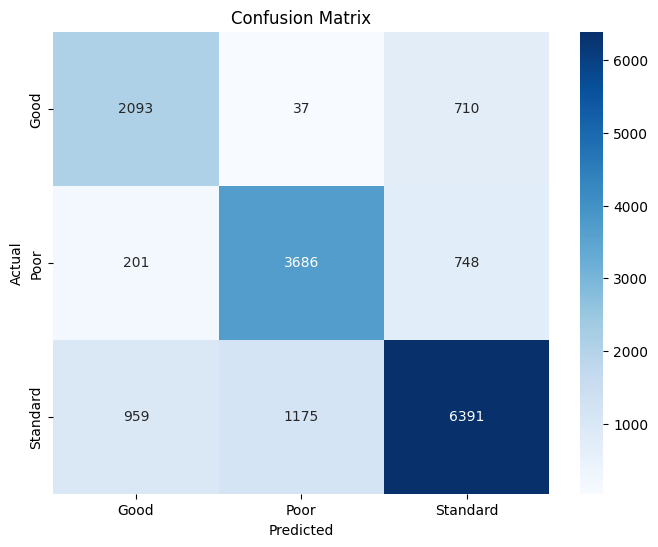

In [251]:
# # Confusion Matrix
# ##################

# # A confusion matrix for 3 variables is a table that visually represents how well a classification model performs when 
# # predicting three different categories, where each row represents the actual class and each column represents the predicted class,
# # resulting in a 3x3 grid that shows how many instances were correctly classified and how many were misclassified between each 
# # of the three possible categories; essentially, it provides a detailed breakdown of the model's errors for each class in 
# # a multi-class classification problem.

# # Key points about a 3-variable confusion matrix:
# ################################################
# # Structure:
# # The matrix has 3 rows and 3 columns, where each row represents one of the actual classes and each column represents one of the predicted classes. 
 
# # Diagonal elements:
# # The diagonal cells of the matrix represent the correctly classified instances for each class. 
 
# # Off-diagonal elements:
# # The values in off-diagonal cells represent the misclassified instances, showing which class the model tends to confuse with another. 

# # Class labels
# class_labels=['Good', 'Poor', 'Standard']

# plot_prediction_vs_test_categorical(y_tested, y_predicted, class_labels)

In [252]:
# # Explanation of Metrics
# ########################

# # Accuracy: The proportion of correctly classified samples.
# # Precision: The ability of the classifier not to label a negative sample as positive.
# # Recall: The ability of the classifier to find all the positive samples.
# # F1-score: A weighted average of precision and recall.
# # Confusion Matrix: A table showing the number of true positives, true negatives, false positives, and false negatives for each class. 
 
# # Important Considerations:
# # Averaging:
# # The average parameter in precision_score, recall_score, and f1_score can be set to different values:
# # 'macro': Calculates the metric for each label, and finds their unweighted mean.
# # 'micro': Calculates the metric globally by counting the total true positives, false negatives, and false positives.
# # 'weighted': Calculates the metric for each label, and finds their average weighted by support (the number of true instances for each label).
# # Class Imbalances:
# # If your dataset has class imbalances, consider using metrics like f1_score and recall that are less sensitive to this issue.

# # Calculating perofrmace of model
# calculate_performance_multiclass(y_tested, y_predicted)

{'accuracy': 0.760625,
 'precision': 0.736734000491817,
 'recall': 0.7606342520912905,
 'f1_score': 0.7469864887367773,
 'confusion_matrix': array([[2093,   37,  710],
        [ 201, 3686,  748],
        [ 959, 1175, 6391]], dtype=int64)}

# Main Menu

In [ ]:
def mainMenu():
    global df, X_test, y_test, model, encoder
    while True:
        print("\n===============================================")
        print("Menu:")
        print("(1) Load data")
        print("(2) Process (Clean) data")
        print("(3) Train NN")
        print("(4) Generate Predictions")
        print("(5) Quit")
        print("===============================================")
        
        choice = input("Select Option: ")
        
        if choice == '1':
            loadData()
        
        elif choice == '2':
            dataCleaning()
                
        elif choice == '3':
            trainNN()
        
        elif choice == '4':
            predictions()
        
        elif choice == '5':
            print("Exiting the program.")
            break
        
        else:
            print("Invalid option. Please select a valid option.")

if __name__ == "__main__":
    mainMenu()

